# Прогнозирование конечных свойств новых материалов (композиционных материалов) - часть 1

**Цель проекта**: сократить количество проводимых испытаний, а также пополнить базу данных материалов возможными новыми характеристиками материалов, и цифровыми двойниками новых композитов. Необходимо спрогнозировать ряд конечных свойств получаемых композиционных материалов.

**Исходные данные**: данные о начальных свойствах компонентов композиционных материалов (количество связующего, наполнителя, температурный режим отверждения и т.д.). 

Данные со свойствами композитов состоят из 2 файлов:

- `X_bp`
- `X_nup`

**Описание**:

Композиционные материалы - это искусственно созданные материалы, состоящие из нескольких других с четкой границей между ними. Композиты обладают теми свойствами, которые не наблюдаются у компонентов по отдельности. При этом композиты являются монолитным материалом, т.е. компоненты материала неотделимы друг от друга без разрушения конструкции в целом. Яркий пример композита - железобетон. Бетон прекрасно сопротивляется сжатию, но плохо растяжению. Стальная арматура внутри бетона компенсирует его неспособность сопротивляться сжатию, формируя тем самым новые, уникальные свойства. 

Современные композиты изготавливаются из других материалов: полимеры, керамика, стеклянные и углеродные волокна, но данный принцип сохраняется. У такого подхода есть и недостаток: даже если мы знаем характеристики исходных компонентов, определить характеристики композита, состоящего из этих компонентов, достаточно проблематично. Для решения этой проблемы есть два пути: физические испытания образцов материалов, или прогнозирование характеристик. Суть прогнозирования заключается в симуляции представительного элемента объема композита, на основе данных о характеристиках входящих компонентов (связующего и армирующего компонента).

##  Загрузка данных и библиотек

Подгрузим библиотеки, требуемые для выполнения проекта:

In [76]:
# Блок импорта
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')
import re
import numpy as np
import time

# Подготовка выборок
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from numpy.random import RandomState
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline

# метрики
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import  make_scorer

# Модели
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

# Для нейронной сети
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, ReLU
from sklearn.model_selection import train_test_split
from keras.metrics import MeanSquaredError
from keras import backend as K
from keras.optimizers import adam_v2
from tensorflow.keras import layers

# Печать жирного шрифта
class color:         
    BOLD = '\033[1m'
    END = '\033[0m'
    
# Переменные
RANDOM_STATE = 4122022

In [77]:
# Вызовем файлы с данными:
    
df_1 = pd.read_excel("E:\X_bp.xlsx", index_col=0)
df_2 = pd.read_excel("E:\X_nup.xlsx", index_col=0)

## Разведочный анализ и предобработка данных

### Предварительное изучение данных

In [78]:
# Вывод общей информации о данных:
   
print(color.BOLD + "X_bp"+ color.END)
print()
df_1.info() 
print()
print('-----------------------------------------------------------------------')
print(color.BOLD + "X_nup"+ color.END)
print()
df_2.info() 
print()
print('-----------------------------------------------------------------------')
display(df_1.head(5).T)
df_2.head(5).T

X_bp

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1023 entries, 0.0 to 1022.0
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп,%_2       1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
dtypes: float64(10)
memory usage: 87.9 KB

----------------------------------

0.0          1.0          2.0  \
Соотношение матрица-наполнитель          1.857143     1.857143     1.857143   
Плотность, кг/м3                      2030.000000  2030.000000  2030.000000   
модуль упругости, ГПа                  738.736842   738.736842   738.736842   
Количество отвердителя, м.%             30.000000    50.000000    49.900000   
Содержание эпоксидных групп,%_2         22.267857    23.750000    33.000000   
Температура вспышки, С_2               100.000000   284.615385   284.615385   
Поверхностная плотность, г/м2          210.000000   210.000000   210.000000   
Модуль упругости при растяжении, ГПа    70.000000    70.000000    70.000000   
Прочность при растяжении, МПа         3000.000000  3000.000000  3000.000000   
Потребление смолы, г/м2                220.000000   220.000000   220.000000   

                                              3.0          4.0  
Соотношение матрица-наполнитель          1.857143     2.771331  
Плотность, кг/м3                      2030.000000  2030.000000  
модуль упругости, ГПа                  738.736842   753.000000  
Количество отвердителя, м.%            129.000000   111.860000  
Содержание эпоксидных групп,%_2         21.250000    22.267857  
Температура вспышки, С_2               300.000000   284.615385  
Поверхностная плотность, г/м2          210.000000   210.000000  
Модуль упругости при растяжении, ГПа    70.000000    70.000000  
Прочность при растяжении, МПа         3000.000000  3000.000000  
Потребление смолы, г/м2                220.000000   220.000000

0.0   1.0   2.0   3.0   4.0
Угол нашивки, град   0.0   0.0   0.0   0.0   0.0
Шаг нашивки          4.0   4.0   4.0   5.0   5.0
Плотность нашивки   57.0  60.0  70.0  47.0  57.0

Пропусков в данных нет, все признаки имеют тип данных float64. 

В талице "X_bp" 1023 объекта и 10 признаков, в талице "X_nup" 1040 объектов и 3 признака.

### Объединение таблиц

In [79]:
# Объединим таблицы по индексу тип объединения INNER

df = df_1.join(df_2,how='inner') 
print(color.BOLD + "df"+ color.END)
print()
df.info() 
print()
print('-----------------------------------------------------------------------')
df.head(5).T

df

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1023 entries, 0.0 to 1022.0
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп,%_2       1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
 10  Угол нашивки, град                    1023 non-null   float64
 11  Шаг наш

0.0          1.0          2.0  \
Соотношение матрица-наполнитель          1.857143     1.857143     1.857143   
Плотность, кг/м3                      2030.000000  2030.000000  2030.000000   
модуль упругости, ГПа                  738.736842   738.736842   738.736842   
Количество отвердителя, м.%             30.000000    50.000000    49.900000   
Содержание эпоксидных групп,%_2         22.267857    23.750000    33.000000   
Температура вспышки, С_2               100.000000   284.615385   284.615385   
Поверхностная плотность, г/м2          210.000000   210.000000   210.000000   
Модуль упругости при растяжении, ГПа    70.000000    70.000000    70.000000   
Прочность при растяжении, МПа         3000.000000  3000.000000  3000.000000   
Потребление смолы, г/м2                220.000000   220.000000   220.000000   
Угол нашивки, град                       0.000000     0.000000     0.000000   
Шаг нашивки                              4.000000     4.000000     4.000000   
Плотность нашивки                       57.000000    60.000000    70.000000   

                                              3.0          4.0  
Соотношение матрица-наполнитель          1.857143     2.771331  
Плотность, кг/м3                      2030.000000  2030.000000  
модуль упругости, ГПа                  738.736842   753.000000  
Количество отвердителя, м.%            129.000000   111.860000  
Содержание эпоксидных групп,%_2         21.250000    22.267857  
Температура вспышки, С_2               300.000000   284.615385  
Поверхностная плотность, г/м2          210.000000   210.000000  
Модуль упругости при растяжении, ГПа    70.000000    70.000000  
Прочность при растяжении, МПа         3000.000000  3000.000000  
Потребление смолы, г/м2                220.000000   220.000000  
Угол нашивки, град                       0.000000     0.000000  
Шаг нашивки                              5.000000     5.000000  
Плотность нашивки                       47.000000    57.000000

Итоговая таблица "df" состоит из 13 признаков и 1023 наблюдений.

In [80]:
# Изменим запись названия столбцов на нижний регистр

df.columns = map(str.lower, df.columns)

### Поиск аномалий в данных


Гистограмма и ящик с усами для признака: соотношение матрица-наполнитель


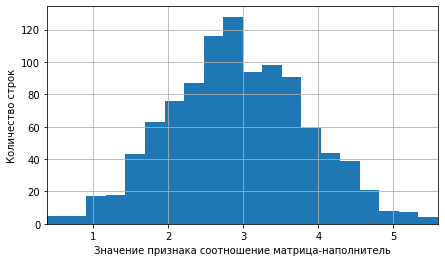

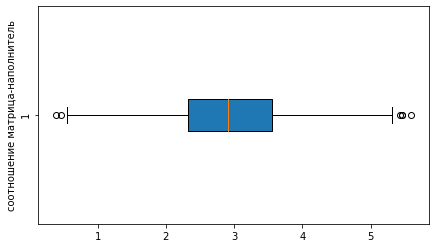

Нижний ус: 0.4657267649425636
Верхний ус: 5.4048197761021415

count    1023.000000
mean        2.930366
std         0.913222
min         0.389403
25%         2.317887
50%         2.906878
75%         3.552660
max         5.591742
Name: соотношение матрица-наполнитель, dtype: float64

6 строк содержат выбросы в столбце соотношение матрица-наполнитель
-------------------------------------------------------------------------------------------------------


Гистограмма и ящик с усами для признака: плотность, кг/м3


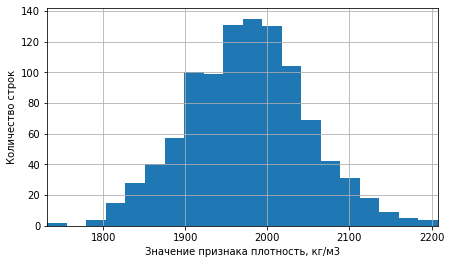

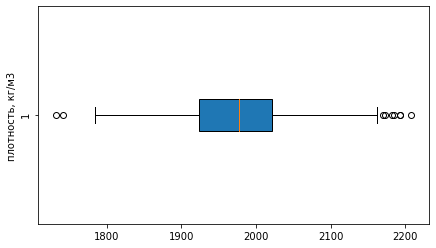

Нижний ус: 1778.3271053007102
Верхний ус: 2167.20273608743

count    1023.000000
mean     1975.734888
std        73.729231
min      1731.764635
25%      1924.155467
50%      1977.621657
75%      2021.374375
max      2207.773481
Name: плотность, кг/м3, dtype: float64

9 строк содержат выбросы в столбце плотность, кг/м3
-------------------------------------------------------------------------------------------------------


Гистограмма и ящик с усами для признака: модуль упругости, гпа


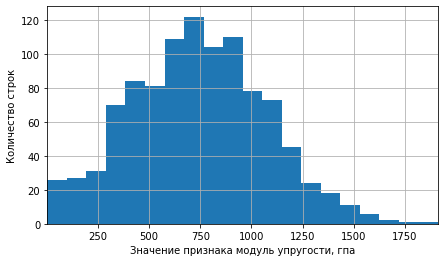

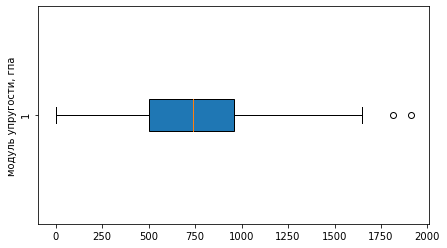

Нижний ус: 2.4369087535075
Верхний ус: 1654.4601385737328

count    1023.000000
mean      739.923233
std       330.231581
min         2.436909
25%       500.047452
50%       739.664328
75%       961.812526
max      1911.536477
Name: модуль упругости, гпа, dtype: float64

2 строк содержат выбросы в столбце модуль упругости, гпа
-------------------------------------------------------------------------------------------------------


Гистограмма и ящик с усами для признака: количество отвердителя, м.%


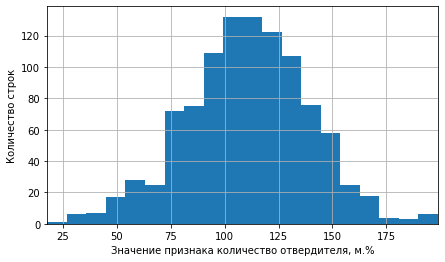

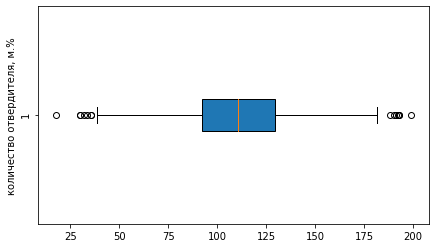

Нижний ус: 36.51319505659012
Верхний ус: 185.66066810509074

count    1023.000000
mean      110.570769
std        28.295911
min        17.740275
25%        92.443497
50%       110.564840
75%       129.730366
max       198.953207
Name: количество отвердителя, м.%, dtype: float64

14 строк содержат выбросы в столбце количество отвердителя, м.%
-------------------------------------------------------------------------------------------------------


Гистограмма и ящик с усами для признака: содержание эпоксидных групп,%_2


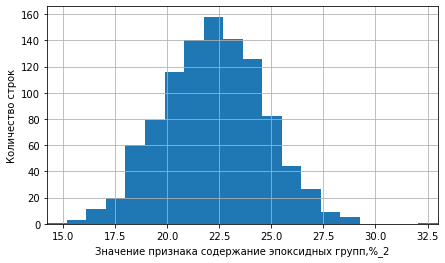

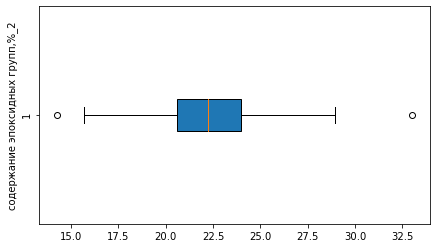

Нижний ус: 15.57718502104257
Верхний ус: 28.99278301000118

count    1023.000000
mean       22.244390
std         2.406301
min        14.254985
25%        20.608034
50%        22.230744
75%        23.961934
max        33.000000
Name: содержание эпоксидных групп,%_2, dtype: float64

2 строк содержат выбросы в столбце содержание эпоксидных групп,%_2
-------------------------------------------------------------------------------------------------------


Гистограмма и ящик с усами для признака: температура вспышки, с_2


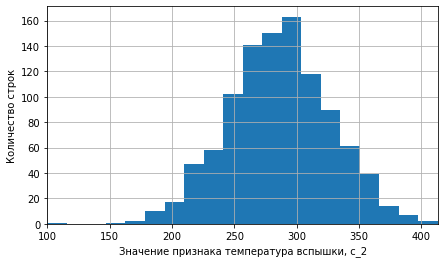

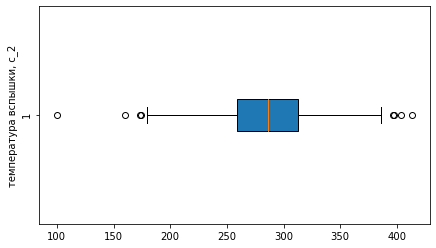

Нижний ус: 178.16316129355107
Верхний ус: 393.90547204494294

count    1023.000000
mean      285.882151
std        40.943260
min       100.000000
25%       259.066528
50%       285.896812
75%       313.002106
max       413.273418
Name: температура вспышки, с_2, dtype: float64

8 строк содержат выбросы в столбце температура вспышки, с_2
-------------------------------------------------------------------------------------------------------


Гистограмма и ящик с усами для признака: поверхностная плотность, г/м2


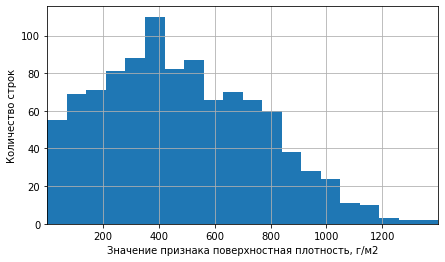

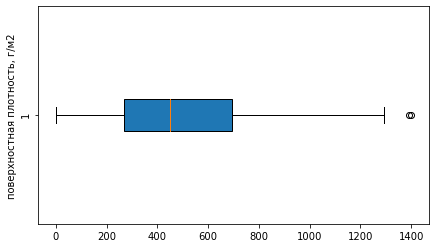

Нижний ус: 0.603739925153945
Верхний ус: 1332.8375748615078

count    1023.000000
mean      482.731833
std       281.314690
min         0.603740
25%       266.816645
50%       451.864365
75%       693.225017
max      1399.542362
Name: поверхностная плотность, г/м2, dtype: float64

2 строк содержат выбросы в столбце поверхностная плотность, г/м2
-------------------------------------------------------------------------------------------------------


Гистограмма и ящик с усами для признака: модуль упругости при растяжении, гпа


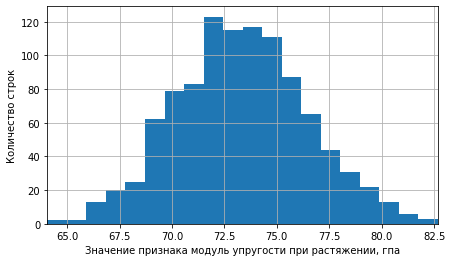

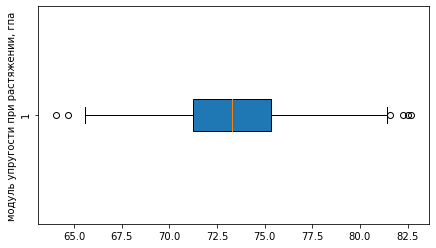

Нижний ус: 65.07762785935806
Верхний ус: 81.52400254670003

count    1023.000000
mean       73.328571
std         3.118983
min        64.054061
25%        71.245018
50%        73.268805
75%        75.356612
max        82.682051
Name: модуль упругости при растяжении, гпа, dtype: float64

6 строк содержат выбросы в столбце модуль упругости при растяжении, гпа
-------------------------------------------------------------------------------------------------------


Гистограмма и ящик с усами для признака: прочность при растяжении, мпа


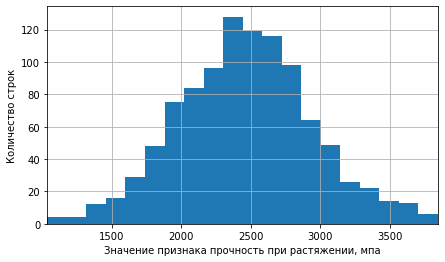

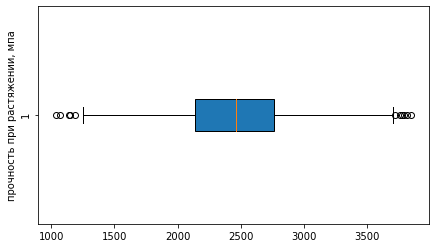

Нижний ус: 1188.8364417822172
Верхний ус: 3714.2071255870374

count    1023.000000
mean     2466.922843
std       485.628006
min      1036.856605
25%      2135.850448
50%      2459.524526
75%      2767.193119
max      3848.436732
Name: прочность при растяжении, мпа, dtype: float64

11 строк содержат выбросы в столбце прочность при растяжении, мпа
-------------------------------------------------------------------------------------------------------


Гистограмма и ящик с усами для признака: потребление смолы, г/м2


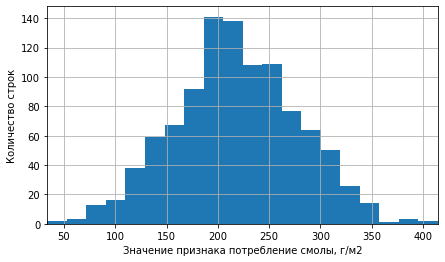

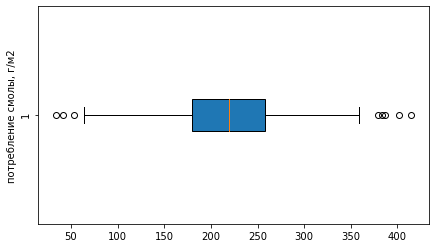

Нижний ус: 62.84621449241624
Верхний ус: 374.2630297955743

count    1023.000000
mean      218.423144
std        59.735931
min        33.803026
25%       179.627520
50%       219.198882
75%       257.481724
max       414.590628
Name: потребление смолы, г/м2, dtype: float64

8 строк содержат выбросы в столбце потребление смолы, г/м2
-------------------------------------------------------------------------------------------------------


Гистограмма и ящик с усами для признака: угол нашивки, град


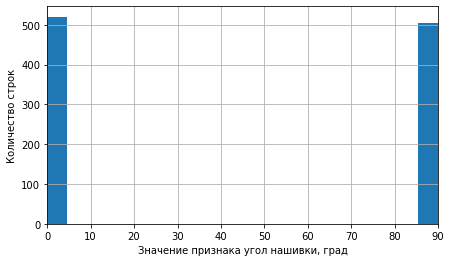

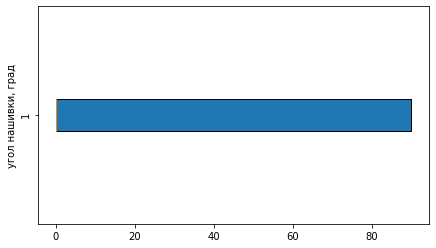

Нижний ус: 0.0
Верхний ус: 225.0

count    1023.000000
mean       44.252199
std        45.015793
min         0.000000
25%         0.000000
50%         0.000000
75%        90.000000
max        90.000000
Name: угол нашивки, град, dtype: float64

0 строк содержат выбросы в столбце угол нашивки, град
-------------------------------------------------------------------------------------------------------


Гистограмма и ящик с усами для признака: шаг нашивки


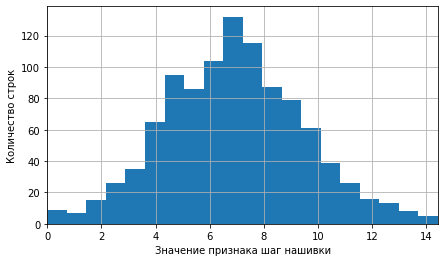

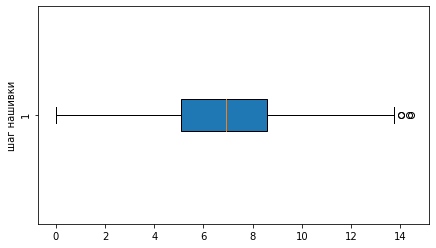

Нижний ус: 0.0
Верхний ус: 13.845682536538867

count    1023.000000
mean        6.899222
std         2.563467
min         0.000000
25%         5.080033
50%         6.916144
75%         8.586293
max        14.440522
Name: шаг нашивки, dtype: float64

4 строк содержат выбросы в столбце шаг нашивки
-------------------------------------------------------------------------------------------------------


Гистограмма и ящик с усами для признака: плотность нашивки


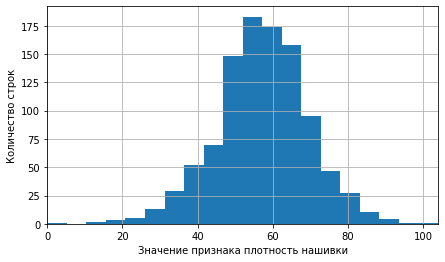

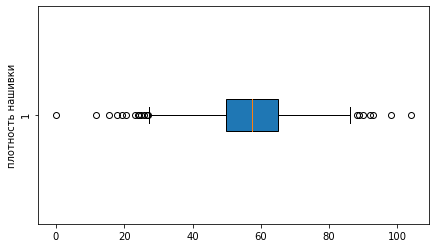

Нижний ус: 27.08058869124911
Верхний ус: 87.66358461459389

count    1023.000000
mean       57.153929
std        12.350969
min         0.000000
25%        49.799212
50%        57.341920
75%        64.944961
max       103.988901
Name: плотность нашивки, dtype: float64

21 строк содержат выбросы в столбце плотность нашивки
-------------------------------------------------------------------------------------------------------

Всего строк с выбросами в данных: 93
Процент строк с выбросами в данных от всего датафрейма: 9.09%


In [81]:
# Построим гистограммы и ящик с усами для признаков

x = list(df.columns.values) # создадим список с названиями признаков
count_outliers = 0

def lower_upper_whisker(i):
    """ Функция для расчета значения верхнего и нижнего уса
    i = индекс названия столбца в списке x """
    
    table=df[x[i]].describe()
    
    if table[4]-1.5*(table[6]-table[4])<table[3]:
        p_lower = table[3]
    else:
        p_lower = table[4]-1.5*(table[6]-table[4])       
    p_upper = table[6]+1.5*(table[6]-table[4])
   
    return p_lower, p_upper


for i in range(len(x)):
 
    print('')
    print(color.BOLD + "Гистограмма и ящик с усами для признака: "+ x[i] + color.END)
    
    plt.figure(figsize=(5,4))
    df[x[i]].hist(bins=20, figsize=(7,4))
    plt.xlabel('Значение признака ' + x[i])
    plt.ylabel('Количество строк')
    plt.xlim(df[x[i]].min(), df[x[i]].max())
    plt.show()

    plt.figure(figsize=(7,4))
    plt.boxplot(df[x[i]], vert=False, labels=None, patch_artist=True)
    plt.yticks(rotation=90)
    plt.ylabel(x[i])
    plt.show()  
    
    p_lower, p_upper = lower_upper_whisker(i)
    print("Нижний ус:",p_lower)
    print("Верхний ус:",p_upper)
    
    print('')    
    print(df[x[i]].describe())   
        
    print('')
    print((len(df[df[x[i]] > p_upper]) + len(df[df[x[i]] < p_lower])),'строк содержат выбросы в столбце', x[i])
    count_outliers += (len(df[df[x[i]] > p_upper]) + len(df[df[x[i]] < p_lower]))

    print('-------------------------------------------------------------------------------------------------------')  
    print('')
    
print("Всего строк с выбросами в данных:", count_outliers)
print("Процент строк с выбросами в данных от всего датафрейма: {:.2%}".format(count_outliers/len(df)))

Гистограмы показывают, что распределение данных близко к нормальному распределению. Во всех столбцах наблюдаются небольшие выбросы, кроме столбца "угол нашивки, град".

In [82]:
# В данных строк с выбросами в данных меньше 10%, удалим выбросы из данных

# Перед удалением сохраним исходный датасет в отдельную переменную для анализа влияния выбросов на результат работы моделей
df_1 = df.copy()

x.remove('угол нашивки, град',)

print(df.shape[0])

for i in range(len(x)):
    
    p_lower, p_upper = lower_upper_whisker(i)
 
    df = df[df[x[i]] < p_upper]
    df = df[df[x[i]] > p_lower]
    
print(df.shape[0])

1023
930


In [83]:
# Проверим на наличие дубликатов
if df.duplicated().sum() == 0:
    print(color.BOLD + "Дубликатов в данных df нет."+ color.END)
else:
    print(color.BOLD + "Количество дубликатов в df:", data.duplicated().sum()+ color.END)  
print()
print('-------------------------------------------------------------------------------------------------------------------')
if df_1.duplicated().sum() == 0:
    print(color.BOLD + "Дубликатов в данных df_1 нет."+ color.END)
else:
    print(color.BOLD + "Количество дубликатов в df_1:", data.duplicated().sum()+ color.END)  
print()
print('-------------------------------------------------------------------------------------------------------------------')

Дубликатов в данных df нет.

-------------------------------------------------------------------------------------------------------------------
Дубликатов в данных df_1 нет.

-------------------------------------------------------------------------------------------------------------------


### Построение матрицы корреляции

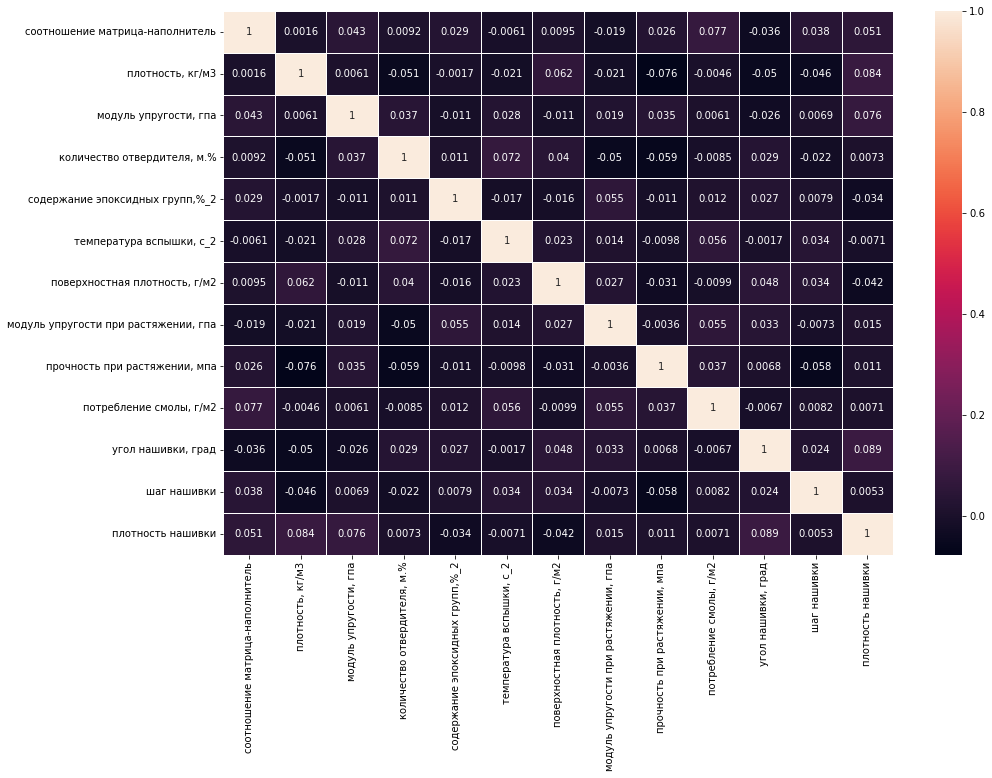

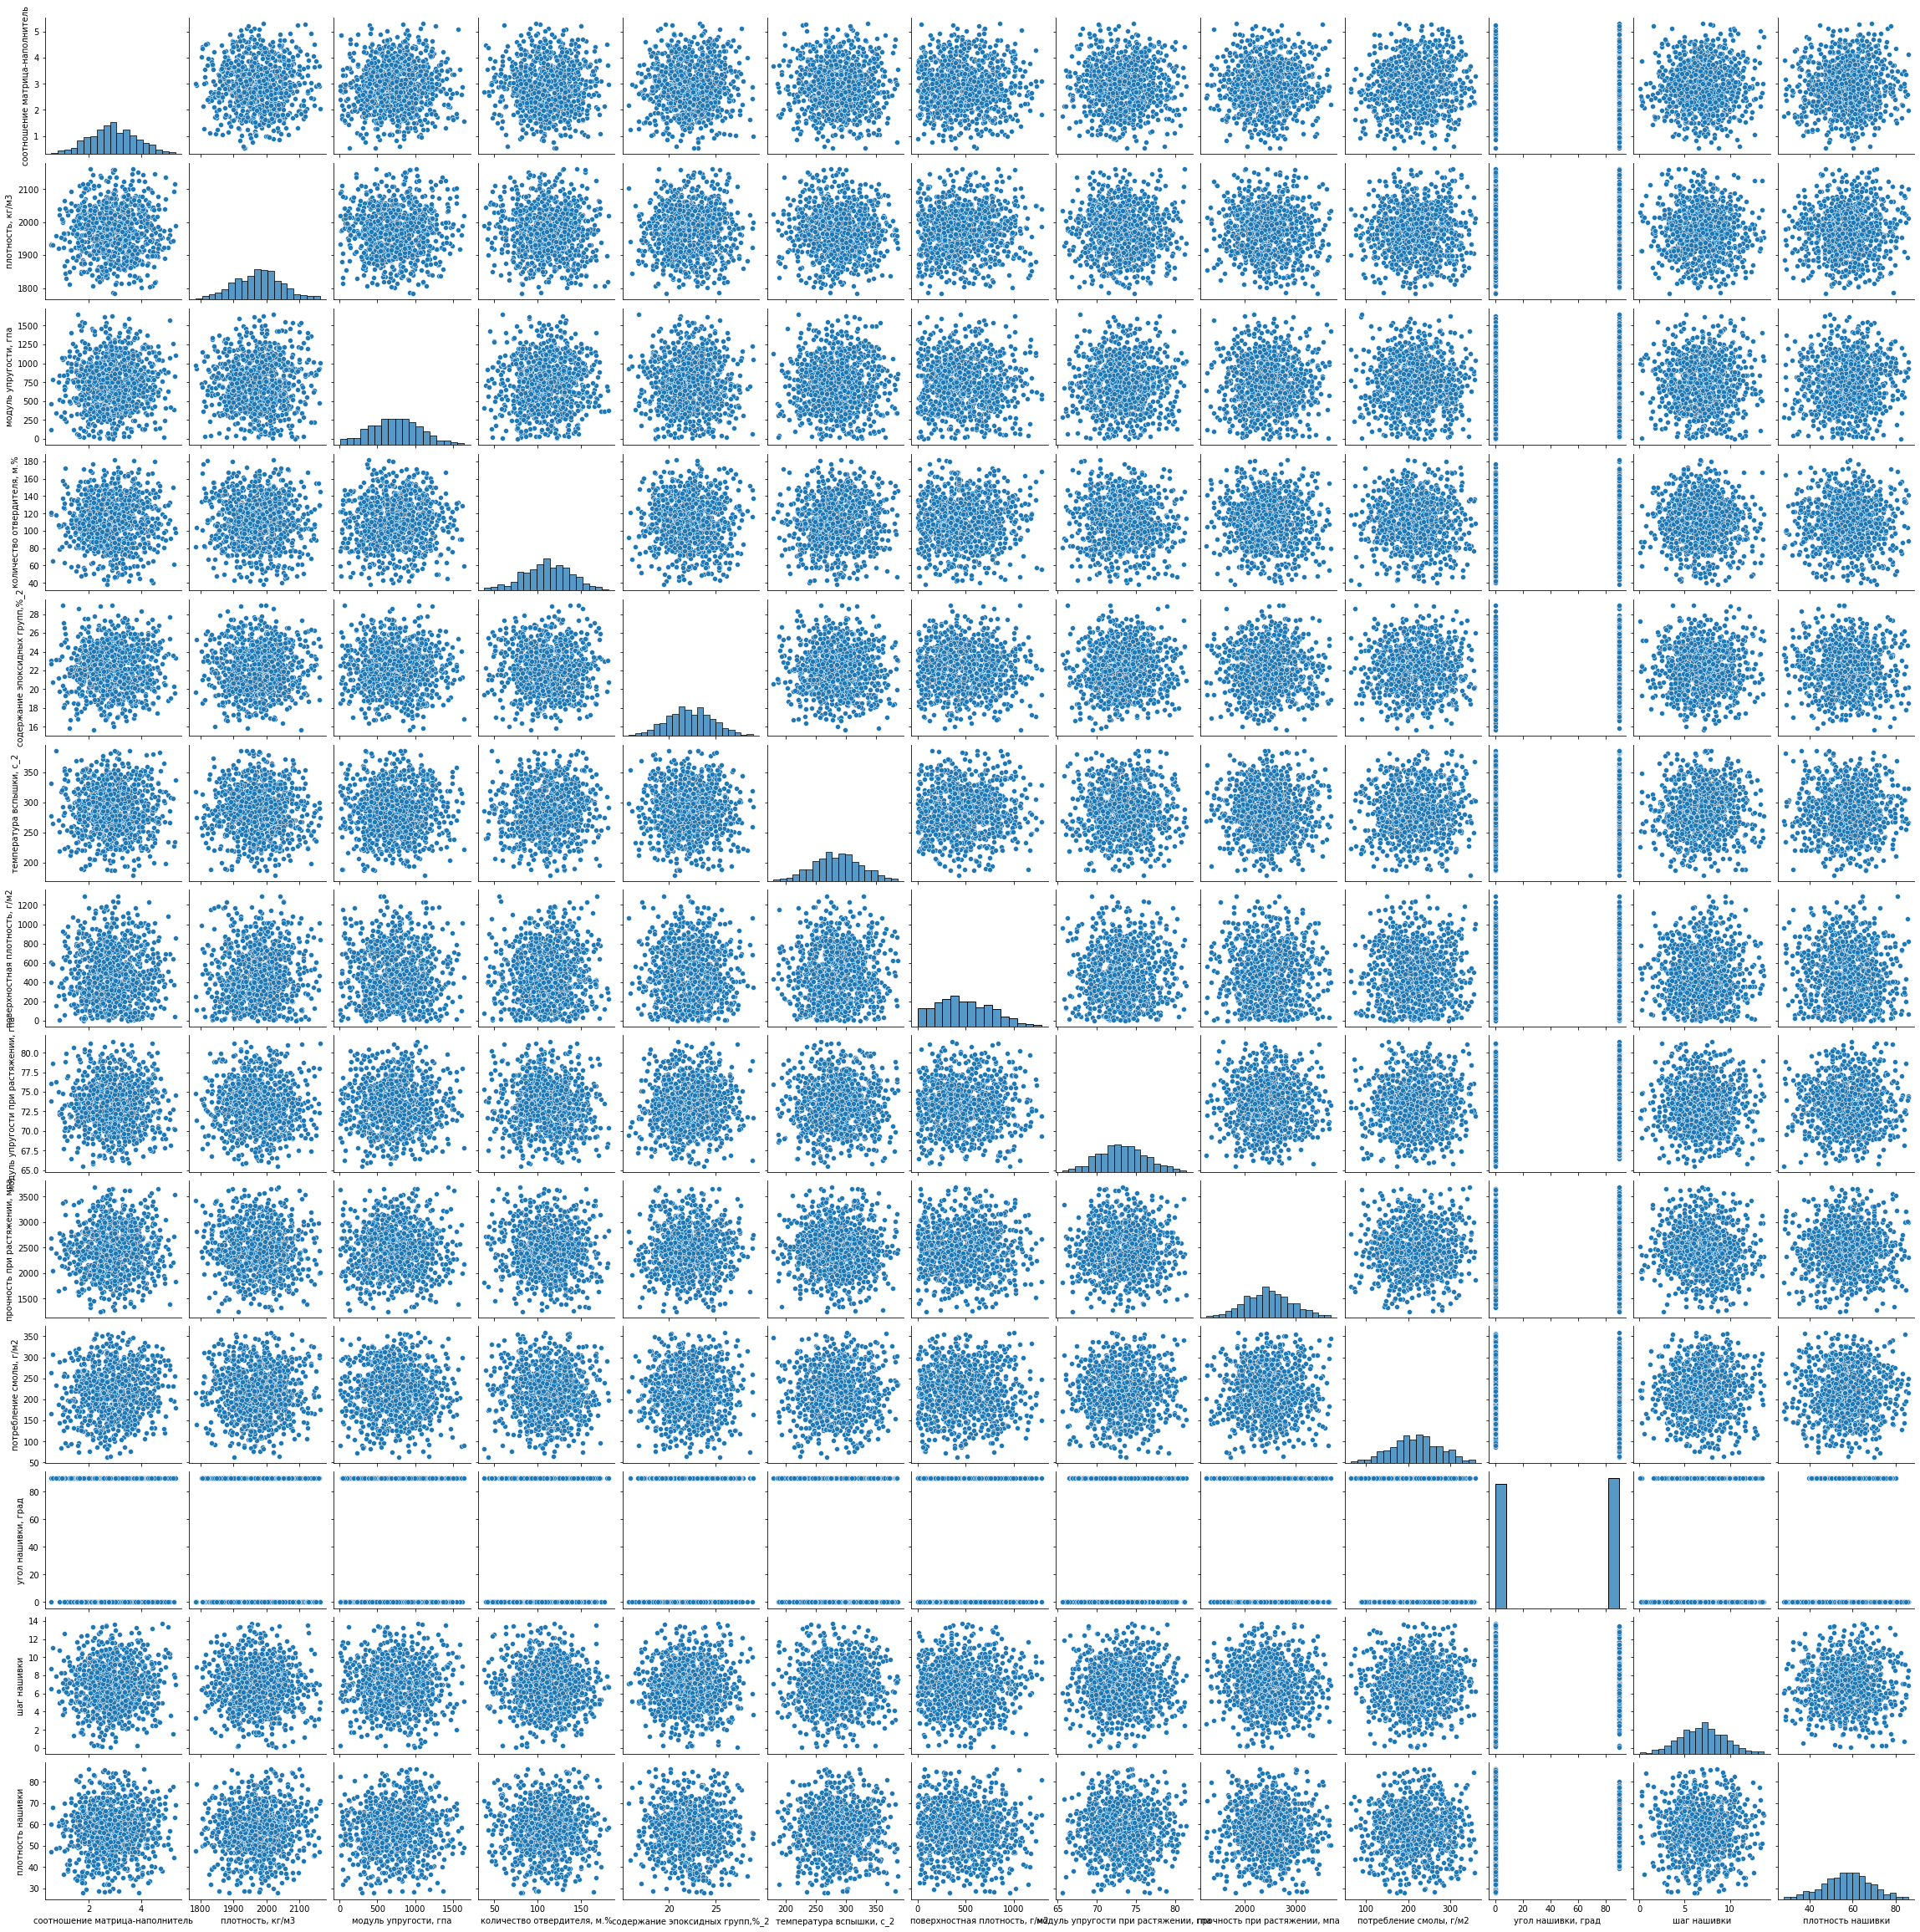

In [84]:
# Посмотрим на матрицу корреляции и выведем попарные графики рассеяния точек для 'df'

plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, linewidths=.6)
plt.show()

sns.pairplot(df)

Записываем предобработанные данные в csv для других частей ноутбуков:

In [131]:
df_s.to_csv('E:/df_s.csv')
df_1_s.to_csv('E:/df_1_s.csv') 

### Вывод

В данном разделе были вызваны необходимые библиотеки, загружены данные и сохранены в переменные "df_1" и "df_2".

Таблица "df_1" содержит 1023 объекта и 10 признаков.
Таблица "df_2" содержит 1040 объектов и 3 признака.

Таблицы были объединены по индексу тип объединения INNER, 17 строк было отброшено.

Были построены гистограммы всех признаков, распределение всех признаков близко к нормальному. Были построены графики ящик с усами, они показыли наличие выбросов. Всего было определено 93 строки с выбросами (9,09% от всего датасета)

Дубликатов во всех данных нет. Пропущенные значения нет. 

Была построена матрица корреляции и графики рассеяния. Графики рассеяния не показывают какой-либо зависимости между параметрами, также можно заметить, что данные нелинейные.
Данные представляют из себя облако точек, что может затруднить работу линейных моделей.

По матрице корреляции также видно отсутствии зависимости между переменными.

## Обучение моделей для прогноза модуля упругости при растяжении

### Нормализация данных

<AxesSubplot:ylabel='Density'>

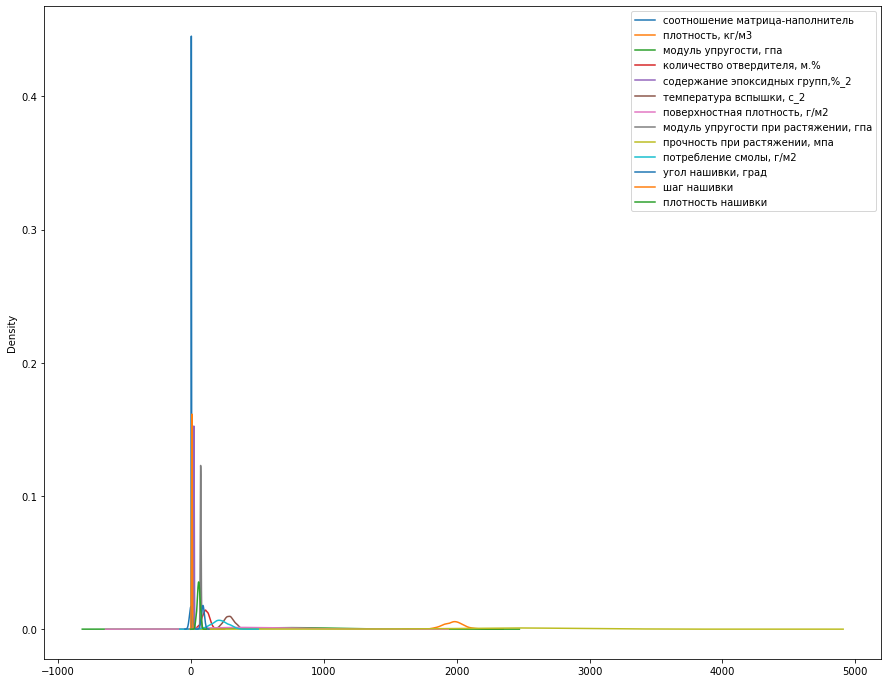

In [85]:
fig, ax = plt.subplots(figsize=(15, 12))
df.plot(kind='kde', ax=ax)

Диапазоны данных сильно расходятся. Выполним нормализацию minmaxscaller.

In [86]:
# Нормализуем данные

# Нормализуем датасеты до удаления выбросов и после

def scal_df(df):
    display(df.head(2))
    scaler = MinMaxScaler()
    names = df.columns
    d = scaler.fit_transform(df)

    df_scaler = pd.DataFrame(d, columns=names)
    display(df.head(2))
    print()
    print('-------------------------------------------------------------------------------------------------------------------')
    return df_scaler

# Нормализованный датасет после удаления выбросов
df_s = scal_df(df)  
# Нормализованный датасет до удаления выбросов
df_1_s = scal_df(df_1)

соотношение матрица-наполнитель  плотность, кг/м3  модуль упругости, гпа  \
1.0                         1.857143            2030.0             738.736842   
3.0                         1.857143            2030.0             738.736842   

     количество отвердителя, м.%  содержание эпоксидных групп,%_2  \
1.0                         50.0                            23.75   
3.0                        129.0                            21.25   

     температура вспышки, с_2  поверхностная плотность, г/м2  \
1.0                284.615385                          210.0   
3.0                300.000000                          210.0   

     модуль упругости при растяжении, гпа  прочность при растяжении, мпа  \
1.0                                  70.0                         3000.0   
3.0                                  70.0                         3000.0   

     потребление смолы, г/м2  угол нашивки, град  шаг нашивки  \
1.0                    220.0                 0.0          4.0   
3.0                    220.0                 0.0          5.0   

     плотность нашивки  
1.0               60.0  
3.0               47.0

соотношение матрица-наполнитель  плотность, кг/м3  модуль упругости, гпа  \
1.0                         1.857143            2030.0             738.736842   
3.0                         1.857143            2030.0             738.736842   

     количество отвердителя, м.%  содержание эпоксидных групп,%_2  \
1.0                         50.0                            23.75   
3.0                        129.0                            21.25   

     температура вспышки, с_2  поверхностная плотность, г/м2  \
1.0                284.615385                          210.0   
3.0                300.000000                          210.0   

     модуль упругости при растяжении, гпа  прочность при растяжении, мпа  \
1.0                                  70.0                         3000.0   
3.0                                  70.0                         3000.0   

     потребление смолы, г/м2  угол нашивки, град  шаг нашивки  \
1.0                    220.0                 0.0          4.0   
3.0                    220.0                 0.0          5.0   

     плотность нашивки  
1.0               60.0  
3.0               47.0


-------------------------------------------------------------------------------------------------------------------


соотношение матрица-наполнитель  плотность, кг/м3  модуль упругости, гпа  \
0.0                         1.857143            2030.0             738.736842   
1.0                         1.857143            2030.0             738.736842   

     количество отвердителя, м.%  содержание эпоксидных групп,%_2  \
0.0                         30.0                        22.267857   
1.0                         50.0                        23.750000   

     температура вспышки, с_2  поверхностная плотность, г/м2  \
0.0                100.000000                          210.0   
1.0                284.615385                          210.0   

     модуль упругости при растяжении, гпа  прочность при растяжении, мпа  \
0.0                                  70.0                         3000.0   
1.0                                  70.0                         3000.0   

     потребление смолы, г/м2  угол нашивки, град  шаг нашивки  \
0.0                    220.0                 0.0          4.0   
1.0                    220.0                 0.0          4.0   

     плотность нашивки  
0.0               57.0  
1.0               60.0

соотношение матрица-наполнитель  плотность, кг/м3  модуль упругости, гпа  \
0.0                         1.857143            2030.0             738.736842   
1.0                         1.857143            2030.0             738.736842   

     количество отвердителя, м.%  содержание эпоксидных групп,%_2  \
0.0                         30.0                        22.267857   
1.0                         50.0                        23.750000   

     температура вспышки, с_2  поверхностная плотность, г/м2  \
0.0                100.000000                          210.0   
1.0                284.615385                          210.0   

     модуль упругости при растяжении, гпа  прочность при растяжении, мпа  \
0.0                                  70.0                         3000.0   
1.0                                  70.0                         3000.0   

     потребление смолы, г/м2  угол нашивки, град  шаг нашивки  \
0.0                    220.0                 0.0          4.0   
1.0                    220.0                 0.0          4.0   

     плотность нашивки  
0.0               57.0  
1.0               60.0


-------------------------------------------------------------------------------------------------------------------


In [87]:
# Нормализованный датасет после удаления выбросов
df_s = scal_df(df)  
# Нормализованный датасет до удаления выбросов
df_1_s = scal_df(df_1)

соотношение матрица-наполнитель  плотность, кг/м3  модуль упругости, гпа  \
1.0                         1.857143            2030.0             738.736842   
3.0                         1.857143            2030.0             738.736842   

     количество отвердителя, м.%  содержание эпоксидных групп,%_2  \
1.0                         50.0                            23.75   
3.0                        129.0                            21.25   

     температура вспышки, с_2  поверхностная плотность, г/м2  \
1.0                284.615385                          210.0   
3.0                300.000000                          210.0   

     модуль упругости при растяжении, гпа  прочность при растяжении, мпа  \
1.0                                  70.0                         3000.0   
3.0                                  70.0                         3000.0   

     потребление смолы, г/м2  угол нашивки, град  шаг нашивки  \
1.0                    220.0                 0.0          4.0   
3.0                    220.0                 0.0          5.0   

     плотность нашивки  
1.0               60.0  
3.0               47.0

соотношение матрица-наполнитель  плотность, кг/м3  модуль упругости, гпа  \
1.0                         1.857143            2030.0             738.736842   
3.0                         1.857143            2030.0             738.736842   

     количество отвердителя, м.%  содержание эпоксидных групп,%_2  \
1.0                         50.0                            23.75   
3.0                        129.0                            21.25   

     температура вспышки, с_2  поверхностная плотность, г/м2  \
1.0                284.615385                          210.0   
3.0                300.000000                          210.0   

     модуль упругости при растяжении, гпа  прочность при растяжении, мпа  \
1.0                                  70.0                         3000.0   
3.0                                  70.0                         3000.0   

     потребление смолы, г/м2  угол нашивки, град  шаг нашивки  \
1.0                    220.0                 0.0          4.0   
3.0                    220.0                 0.0          5.0   

     плотность нашивки  
1.0               60.0  
3.0               47.0


-------------------------------------------------------------------------------------------------------------------


соотношение матрица-наполнитель  плотность, кг/м3  модуль упругости, гпа  \
0.0                         1.857143            2030.0             738.736842   
1.0                         1.857143            2030.0             738.736842   

     количество отвердителя, м.%  содержание эпоксидных групп,%_2  \
0.0                         30.0                        22.267857   
1.0                         50.0                        23.750000   

     температура вспышки, с_2  поверхностная плотность, г/м2  \
0.0                100.000000                          210.0   
1.0                284.615385                          210.0   

     модуль упругости при растяжении, гпа  прочность при растяжении, мпа  \
0.0                                  70.0                         3000.0   
1.0                                  70.0                         3000.0   

     потребление смолы, г/м2  угол нашивки, град  шаг нашивки  \
0.0                    220.0                 0.0          4.0   
1.0                    220.0                 0.0          4.0   

     плотность нашивки  
0.0               57.0  
1.0               60.0

соотношение матрица-наполнитель  плотность, кг/м3  модуль упругости, гпа  \
0.0                         1.857143            2030.0             738.736842   
1.0                         1.857143            2030.0             738.736842   

     количество отвердителя, м.%  содержание эпоксидных групп,%_2  \
0.0                         30.0                        22.267857   
1.0                         50.0                        23.750000   

     температура вспышки, с_2  поверхностная плотность, г/м2  \
0.0                100.000000                          210.0   
1.0                284.615385                          210.0   

     модуль упругости при растяжении, гпа  прочность при растяжении, мпа  \
0.0                                  70.0                         3000.0   
1.0                                  70.0                         3000.0   

     потребление смолы, г/м2  угол нашивки, град  шаг нашивки  \
0.0                    220.0                 0.0          4.0   
1.0                    220.0                 0.0          4.0   

     плотность нашивки  
0.0               57.0  
1.0               60.0


-------------------------------------------------------------------------------------------------------------------


<AxesSubplot:ylabel='Density'>

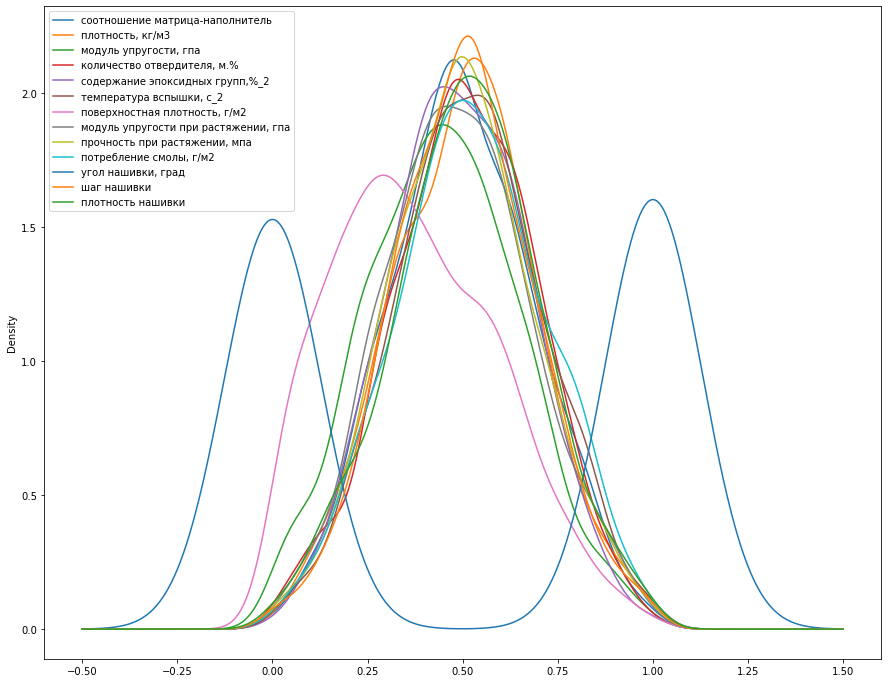

In [88]:
fig, ax = plt.subplots(figsize=(15, 12))
df_s.plot(kind='kde', ax=ax)

In [89]:
# Выведем уникальные значения признака 'угол нашивки, град'
df_s['угол нашивки, град'].unique()

array([0., 1.])

Данный столбец корректировки не требует, значения 0 и 90, заменились на 0 и 1.

Записываем предобработанные данные в csv для других частей ноутбуков:

In [90]:
df_s.to_csv('E:/df_s.csv', sep=';')
df_1_s.to_csv('E:/df_1_s.csv', sep=';') 

### Разбивка данных на выборки

In [91]:
# Создадим датафрейм признаков для данных с выбросами и без

def make_dataset(df, df_name, column):    
    print('Для', df_name)
    print(df.shape)
    
    X = df.drop(column, axis = 1) 
    print(X.shape)  
    print('-----------------------------------------------------------------------------------------------------------------')
    
    return X

In [92]:
X = make_dataset(df_s, '"df_s"', ['модуль упругости при растяжении, гпа','прочность при растяжении, мпа'])     
# Данные без выбросов
X_wo = make_dataset(df_1_s, '"df_1_s"',['модуль упругости при растяжении, гпа','прочность при растяжении, мпа']) 
# Данные с наличием выбросов

Для "df_s"
(930, 13)
(930, 11)
-----------------------------------------------------------------------------------------------------------------
Для "df_1_s"
(1023, 13)
(1023, 11)
-----------------------------------------------------------------------------------------------------------------


In [93]:
# Выделим целевые признаки
def make_target(df, df_name):
    print('Для', df_name)
    
    y_1 = df['модуль упругости при растяжении, гпа']
    y_2 = df['прочность при растяжении, мпа']

    print(y_1.shape) 
    print(y_2.shape)
    print('-----------------------------------------------------------------------------------------------------------------')
    return y_1, y_2

In [94]:
y_1, y_2= make_target(df_s, '"df_s"')
y_1_wo, y_2_wo= make_target(df_1_s, '"df_1_s"') 

Для "df_s"
(930,)
(930,)
-----------------------------------------------------------------------------------------------------------------
Для "df_1_s"
(1023,)
(1023,)
-----------------------------------------------------------------------------------------------------------------


In [95]:
# Разделим в соотношении 70:30, используем функцию train_test_split():

def make_train_test(x, Y_1, Y_2, df, df_name):
    print('Для', df_name)
    x_1_train, x_1_test, Y_1_train, Y_1_test = train_test_split(x, Y_1, test_size=0.30, random_state=RANDOM_STATE)
    x_2_train, x_2_test, Y_2_train, Y_2_test = train_test_split(x, Y_2, test_size=0.30, random_state=RANDOM_STATE)
#    x_3_train, x_3_test, Y_3_train, Y_3_test = train_test_split(x, Y_3, test_size=0.30, random_state=RANDOM_STATE)
    
    print('Общее количество объектов:', df.shape[0])
    print('Обучающая выборка X_train:',  x_1_train.shape[0])
    print('Тестовая выборка X_test:',  x_1_test.shape[0])
    print('-----------------------------------------------------------------------------------------------------------------')
    
    return x_1_train, x_1_test, Y_1_train, Y_1_test, x_2_train, x_2_test, Y_2_train, Y_2_test

In [96]:
X_1_train, X_1_test, y_1_train, y_1_test, X_2_train, X_2_test,y_2_train, y_2_test = make_train_test(X, y_1, y_2, df_s, '"df_s"')

X_1_wo_train, X_1_wo_test, y_1_wo_train, y_1_wo_test, X_2_wo_train,X_2_wo_test, y_2_wo_train, y_2_wo_test = make_train_test(X_wo, y_1_wo, y_2_wo,df_1_s,'"df_1_s"')

Для "df_s"
Общее количество объектов: 930
Обучающая выборка X_train: 651
Тестовая выборка X_test: 279
-----------------------------------------------------------------------------------------------------------------
Для "df_1_s"
Общее количество объектов: 1023
Обучающая выборка X_train: 716
Тестовая выборка X_test: 307
-----------------------------------------------------------------------------------------------------------------


### Выбор, обучение и тестирование моделей

***Модуль упругости при растяжении***

Создадим таблицы для записи результатов работы моделей:

In [97]:
# Таблица для записи результата предсказания признака 'модуль упругости при растяжении, гпа'

results_1 = pd.DataFrame(columns = ['Модель', 'MSE модели', 'r2 модели','Время обучения, с',
         'Время предсказания, с','Общее время, с','Подбор гиперпараметров', 'Значения гиперпараметров', 'Данные'])

def highlight_min(x):
    ''' Функция для выделения в таблице ячейки 
    с минимальным значением метрики '''
    c = 'background-color: green'
    m = x.eq(x.min())
    df = pd.DataFrame('', index=x.index, columns=x.columns)
    return df.mask(m, c)

In [98]:
def custom_metric_r2(target_test, target_predicted):
    r2 = r2_score(target_test, model.predict_proba(features_test)[:,1], multioutput='variance_weighted')
    return г2
def custom_metric_mse(target_test, target_predicted):
    mse = mean_squared_error(target_test, target_predicted)
    return mse

In [136]:
# Для данных без выбросов

def model_analysis_df(model,data, model_info, features_train, target_train, features_test, target_test, selection, 
                      hyperparameters):
    """ Функция для расчета метрик для последующего анализа моделей
    features_train =  обучающая выборка признаков
    target_train = целевой признак для обучающей выборки
    features_test = тестовая выборка признаков
    target_test = целевой признак для тестовой выборки
    data = переменная, содержащая таблицу результатов
    model = модель 
    model_info = название модели 
    hyperparameters = значение гиперпараметров
    selection = подбор гиперпараметров
    selection_time = время подбора гиперпараметра"""
    
    start = time.time()    
    model.fit(features_train, target_train)
    train_time = time.time() - start # время обучения
    
    start = time.time()  
    predicted = model.predict(features_test)
    predict_time = time.time() - start # время предсказания

    score = make_scorer(custom_metric_mse, greater_is_better=True)
    
    scoring = {'r_2': 'r2',
               'mse': score}  
    
    scores = cross_validate(model, features_train, target_train, cv=10, scoring=scoring)
    
    plt.figure(num = 'Prediction', figsize = (15,6), edgecolor = 'k', frameon = True)
    plt.title('Результат работы модели '+ model_info)
    plt.plot(predicted, label = "Прогноз",color = 'b')
    plt.plot(target_test.values, label = "Тест",color = 'k')
    plt.xlabel("Количество наблюдений")
    plt.ylabel("Модуль упругости при растяжении, ГПа")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    data = data.append({'Модель':model_info,
                        'MSE модели':'{:.4f}'.format(scores['test_mse'].mean()),
                        'r2 модели':'{:.4f}'.format(scores['test_r_2'].mean()),
                        'Время обучения, с':'{:.2f}'.format(train_time),
                        'Время предсказания, с':'{:.2f}'.format(predict_time),
                        'Общее время, с':'{:.2f}'.format(train_time + predict_time),
                        'Подбор гиперпараметров': selection,                        
                        'Значения гиперпараметров': hyperparameters, 
                        'Данные': 'df_s'}, ignore_index=True)  
    
    print(color.BOLD + model_info+':'+ color.END)
    print('Время обучения: ', round(train_time, 2), 'с')
    print('Время предсказания: ', round(predict_time, 2), 'с')
    print('MSE модели: ', round(scores['test_mse'].mean(), 4))
    print('r2 модели: ', round(scores['test_r_2'].mean(), 4))
    print('--------------------------------------------------------------------------------------------------------')    
    return data 

# Для данных с выбросами

def model_analysis_df_1(model,data, model_info, features_train, target_train, features_test, target_test, selection, 
                        hyperparameters):
    """ Функция для расчета времени обучения и предсказания, RMSE и для последующего анализа моделей
    features_train =  обучающая выборка признаков
    target_train = целевой признак для обучающей выборки
    features_test = тестовая выборка признаков
    target_test = целевой признак для тестовой выборки
    data = переменная, содержащая таблицу результатов
    model = модель 
    model_info = название модели 
    hyperparameters = значение гиперпараметров
    selection = подбор гиперпараметров
    selection_time = время подбора гиперпараметра"""
    
    start = time.time()    
    model.fit(features_train, target_train)
    train_time = time.time() - start # время обучения
    
    start = time.time()  
    predicted = model.predict(features_test)
    predict_time = time.time() - start # время предсказания
        
    score = make_scorer(custom_metric_mse, greater_is_better=True)
    
    scoring = {'r_2': 'r2',
               'mse': score}  
    
    scores = cross_validate(model, features_train, target_train, cv=10, scoring=scoring)
    
    score = make_scorer(custom_metric_mse, greater_is_better=True)
    
    scoring = {'r_2': 'r2',
               'mse': score}  
    
    scores = cross_validate(model, features_train, target_train, cv=10, scoring=scoring)
    
    plt.figure(num = 'Prediction', figsize = (17,6), edgecolor = 'k', frameon = True)
    plt.title('Результат работы модели '+ model_info)
    plt.plot(predicted, label = "Прогноз",color = 'b')
    plt.plot(target_test.values, label = "Тест",color = 'k')
    plt.xlabel("Количество наблюдений")
    plt.ylabel("Модуль упругости при растяжении, ГПа")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
    data = data.append({'Модель':model_info,
                        'MSE модели':'{:.4f}'.format(scores['test_mse'].mean()),
                        'r2 модели':'{:.4f}'.format(scores['test_r_2'].mean()),
                        'Время обучения, с':'{:.2f}'.format(train_time),
                        'Время предсказания, с':'{:.2f}'.format(predict_time),
                        'Общее время, с':'{:.2f}'.format(train_time + predict_time),
                        'Подбор гиперпараметров': selection,                        
                        'Значения гиперпараметров': hyperparameters, 
                        'Данные': 'df_s_1'}, ignore_index=True)  
          
    print(color.BOLD + model_info+':'+ color.END)
    print('Время обучения: ', round(train_time, 2), 'с')
    print('Время предсказания: ', round(predict_time, 2), 'с')
    print('MSE модели: ', round(scores['test_mse'].mean(), 4))
    print('r2 модели: ', round(scores['test_r_2'].mean(), 4))
    print('--------------------------------------------------------------------------------------------------------')    
    return data 

In [137]:
def selection_hyperparameters(model, params, features_train, target_train, model_name):
    """ Функция для подбора гиперпараметров и расчета времени подбора
    features_train =  обучающая выборка признаков
    target_train = целевой признак для обучающей выборки
    model = модель 
    params = список гиперпараметров для подбора"""
    
    grid = GridSearchCV(model, params, cv=10)

    start = time.time()  
    grid.fit(features_train, target_train)
    selection_time = time.time() - start # время подбора гиперпараметров

    print("Гиперпараметры для модели ", model_name, grid.best_params_)
    print('--------------------------------------------------------------------------------------------------------')
    
    return grid.best_params_ ,grid.best_estimator_#, selection_time 

Расчеты будем вести для данных с выбросами и без.

#### **DummyRegressor**

Для проверки моделей на адекватность, обучим простую модель DummyRegressor, предсказывающую среднее для двух выборок без и с выбросами.

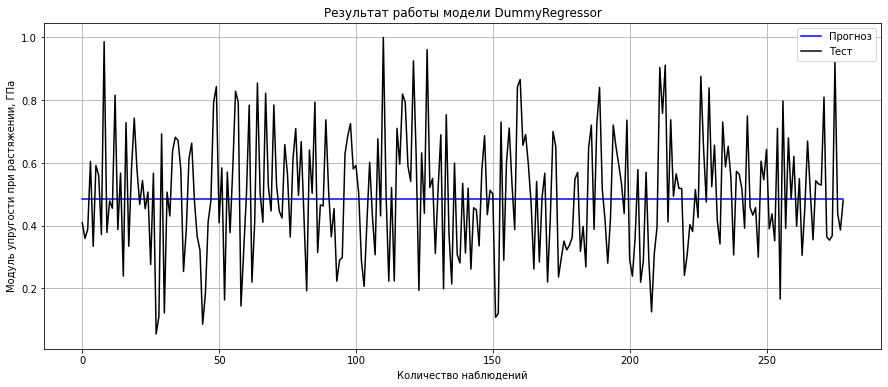

DummyRegressor:
Время обучения:  0.0 с
Время предсказания:  0.0 с
MSE модели:  0.0372
r2 модели:  -0.0322
--------------------------------------------------------------------------------------------------------


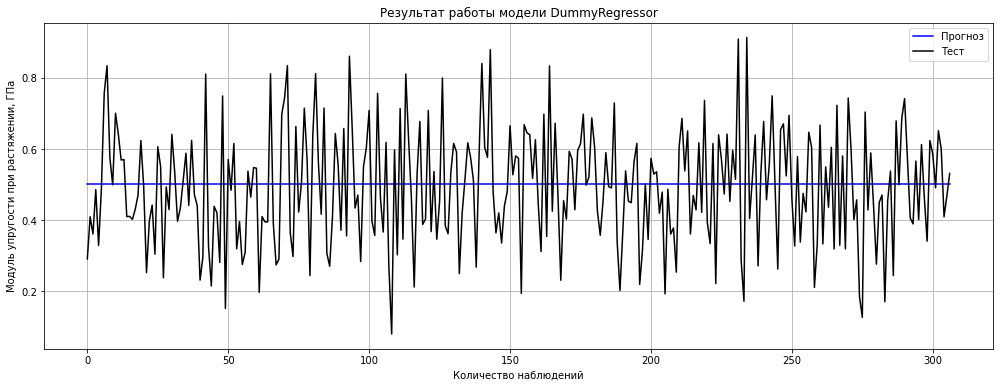

DummyRegressor:
Время обучения:  0.0 с
Время предсказания:  0.0 с
MSE модели:  0.0291
r2 модели:  -0.0323
--------------------------------------------------------------------------------------------------------
Wall time: 1.89 s


In [143]:
%%time

model_dummy = DummyRegressor(strategy='mean')

# Модуль упругости при растяжении

results_1 = model_analysis_df(model_dummy, results_1, 'DummyRegressor',X_1_train, y_1_train, X_1_test, y_1_test,'нет', '-')
results_1 = model_analysis_df_1(model_dummy, results_1, 'DummyRegressor',X_1_wo_train, y_1_wo_train, X_1_wo_test, y_1_wo_test,
                              'нет', '-')

#### Линейные модели

При анализе данных нигде не выявлено было линейной зависимости. Поэтому тренировка линейной модели вряд ли принесет результат.

In [102]:
# Составим словарь и запишем в него модели для расчета

models_0 = {}
models_0['lr'] = LinearRegression()
models_0['Ridge'] = Ridge(random_state=RANDOM_STATE)
models_0['Lasso'] = Lasso(random_state=RANDOM_STATE)
models_0['SGDRegressor'] = SGDRegressor(random_state=RANDOM_STATE)

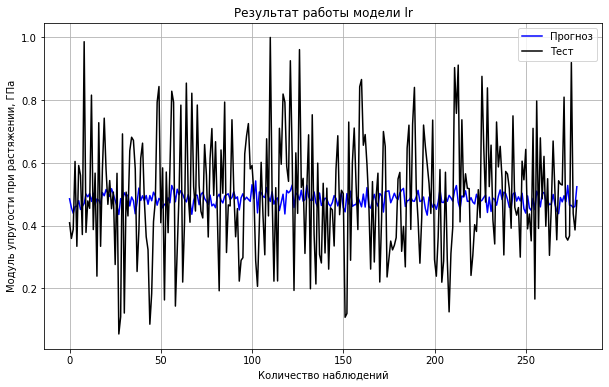

lr:
Время обучения:  0.0 с
Время предсказания:  0.0 с
MSE модели:  0.0383
r2 модели:  -0.0623
--------------------------------------------------------------------------------------------------------


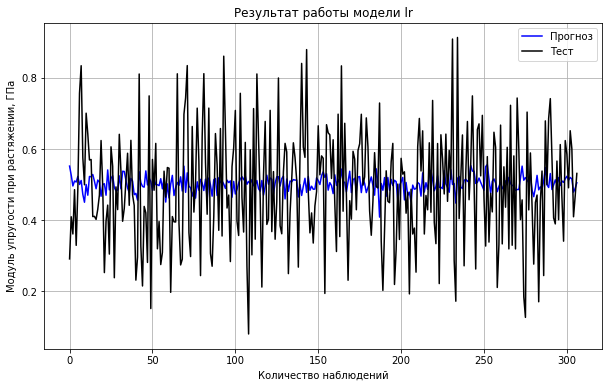

lr:
Время обучения:  0.0 с
Время предсказания:  0.0 с
MSE модели:  0.0296
r2 модели:  -0.0505
--------------------------------------------------------------------------------------------------------


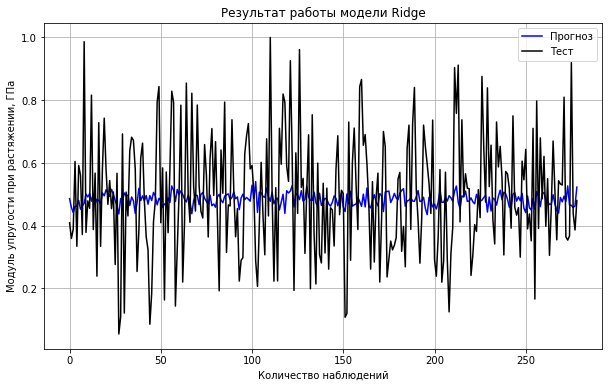

Ridge:
Время обучения:  0.01 с
Время предсказания:  0.0 с
MSE модели:  0.0383
r2 модели:  -0.0603
--------------------------------------------------------------------------------------------------------


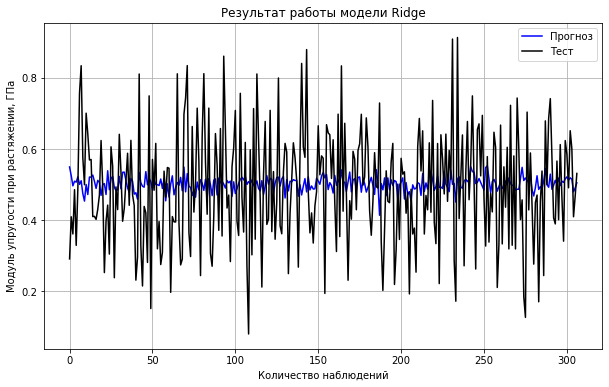

Ridge:
Время обучения:  0.0 с
Время предсказания:  0.0 с
MSE модели:  0.0295
r2 модели:  -0.0482
--------------------------------------------------------------------------------------------------------


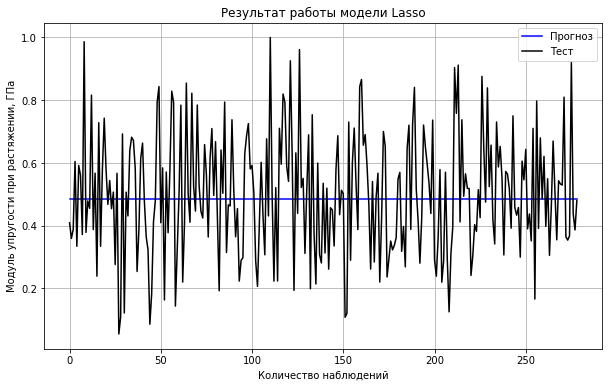

Lasso:
Время обучения:  0.01 с
Время предсказания:  0.0 с
MSE модели:  0.0372
r2 модели:  -0.0322
--------------------------------------------------------------------------------------------------------


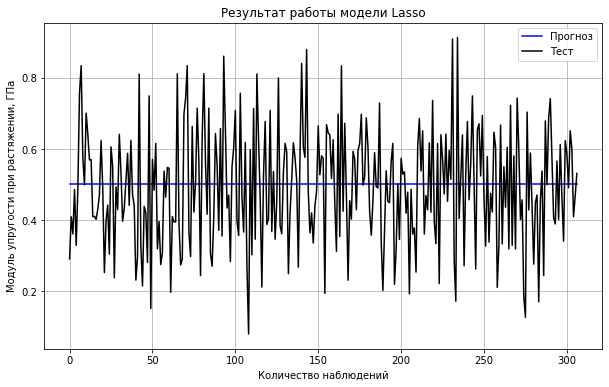

Lasso:
Время обучения:  0.0 с
Время предсказания:  0.0 с
MSE модели:  0.0291
r2 модели:  -0.0323
--------------------------------------------------------------------------------------------------------


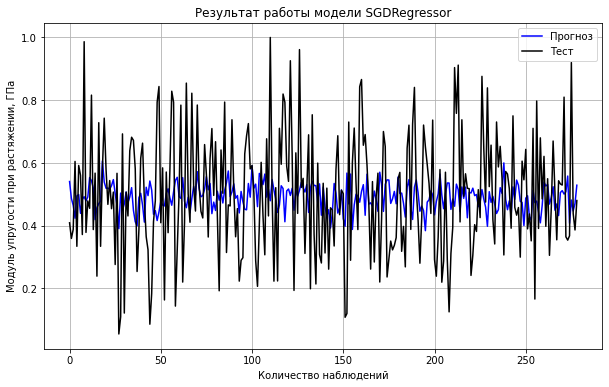

SGDRegressor:
Время обучения:  0.01 с
Время предсказания:  0.0 с
MSE модели:  0.0385
r2 модели:  -0.0676
--------------------------------------------------------------------------------------------------------


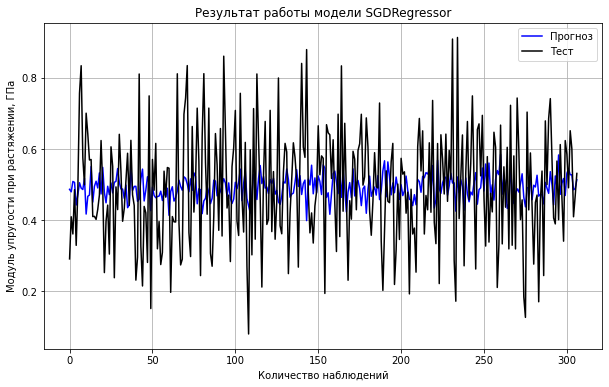

SGDRegressor:
Время обучения:  0.0 с
Время предсказания:  0.0 с
MSE модели:  0.0305
r2 модели:  -0.0875
--------------------------------------------------------------------------------------------------------


In [103]:
for key, value in models_0.items():
    # Для выборки без выбросов
    results_1 = model_analysis_df(value, results_1, key ,X_1_train, y_1_train, X_1_test, y_1_test, 'нет', '-')
    # Для выборки с выбросами
    results_1 = model_analysis_df_1(value, results_1, key ,X_1_wo_train, y_1_wo_train, X_1_wo_test, y_1_wo_test, 'нет', '-')   

Выведем предварительную таблицу и посмотрим на результат работы моделей. Столбец с метрикой MSE отсортируем по возрастанию значения.

In [104]:
results_1.sort_values('MSE модели').style.apply(highlight_min, axis=None, subset=['MSE модели'])

Если мы посмотрим на столбец 'Данные' можно заметить, что данные без выбросов показали метрику хуже. Скорее всего это связано с уменьшением наблюдений в выборке.

Далее модели будем обучать только на полных данных без удаления выбросов, так как удаление повлияло на качество моделей в худшую сторону. 

Также можно заметить, что линейные модели: линейная регрессия, Ridge, Lasso дали результат не намного лучше или такой же как глупая модель, предсказывающая среднее. Скорее всего это связано с нелинейностью данных.

In [105]:
# Удалим строки в таблице для моделей, обученных на данных без выбросов, чтобы таблица не была слишком громоздкой
results_1 = results_1.query('Данные != "df_s"') 

#### Линейные модели, подбор гиперпараметров

Лучшие линейные модели Lasso и Ridge попробуем подобрать к ним гиперпараметры.

In [106]:
# Составим словарь и запишем в него модели для расчета и значения гиперпараметров для подбора

models_3 = {}
models_3['lr_GridSearch'] = LinearRegression()
models_3['Ridge_GridSearch'] = Ridge(random_state=RANDOM_STATE)
models_3['SGDRegressor_GridSearch'] = SGDRegressor(random_state=RANDOM_STATE)
models_3['Lasso_GridSearch'] = Lasso(random_state=RANDOM_STATE)

params = {}
params['lr_GridSearch'] =  {'copy_X':[True, False],
                            'fit_intercept': [True, False],
                            'n_jobs':[None, 1,10],
                            'normalize':[True, False], 
                            'positive':[True, False]}

params['Ridge_GridSearch'] =  { 'solver':['svd', 'cholesky', 'lsqr', 'sag', 'auto'],
                                'alpha': [1, 1.3, 1.4, 10],
                                'fit_intercept':[True, False],
                                'normalize':[True, False], 
                                'fit_intercept':[True, False],
                                'copy_X':[True, False],
                                'max_iter': [None, 1,10,100],
                                'tol': [0.001, 0.002,0.09,1]}

params['Lasso_GridSearch'] =  {'alpha': [1, 1.3, 1.4, 10],
                                'fit_intercept':[True, False],
                                'normalize':[True, False], 
                                'fit_intercept':[True, False],
                                'copy_X':[True, False],
                                'max_iter': [None, 1,10,100],
                                'tol': [0.001, 0.002,0.09,1]}


params['SGDRegressor_GridSearch'] = {'alpha':[3, 4,2],
                                     'shuffle':[True, False],
                                     'warm_start':[True, False],
                                     'eta0': [0.008, 0.007,0.01]}

Гиперпараметры для модели  lr_GridSearch {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': True}
--------------------------------------------------------------------------------------------------------


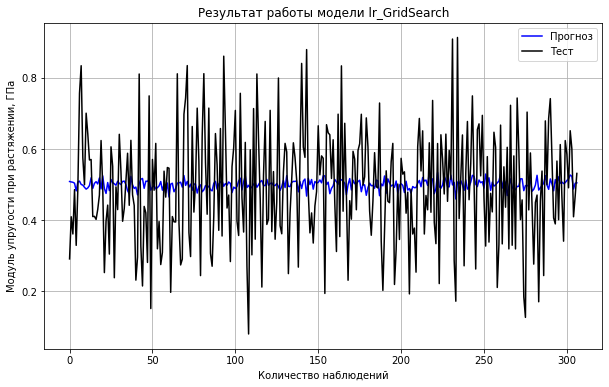

lr_GridSearch:
Время обучения:  0.0 с
Время предсказания:  0.0 с
MSE модели:  0.0296
r2 модели:  -0.0499
--------------------------------------------------------------------------------------------------------
Гиперпараметры для модели  Ridge_GridSearch {'alpha': 10, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': True, 'solver': 'sag', 'tol': 0.09}
--------------------------------------------------------------------------------------------------------


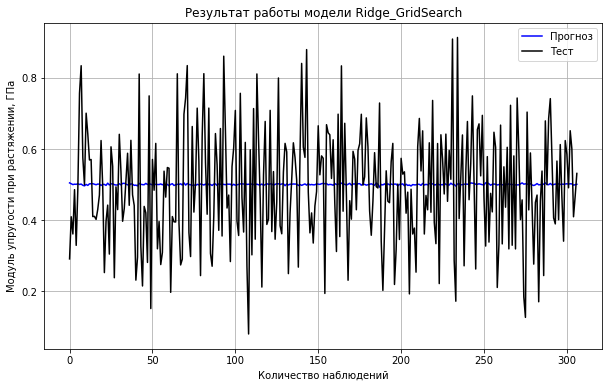

Ridge_GridSearch:
Время обучения:  0.0 с
Время предсказания:  0.0 с
MSE модели:  0.0291
r2 модели:  -0.0325
--------------------------------------------------------------------------------------------------------
Гиперпараметры для модели  SGDRegressor_GridSearch {'alpha': 2, 'eta0': 0.01, 'shuffle': False, 'warm_start': True}
--------------------------------------------------------------------------------------------------------


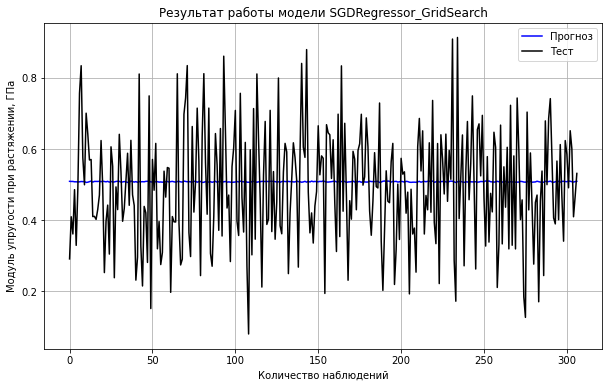

SGDRegressor_GridSearch:
Время обучения:  0.0 с
Время предсказания:  0.0 с
MSE модели:  0.0291
r2 модели:  -0.0311
--------------------------------------------------------------------------------------------------------
Гиперпараметры для модели  Lasso_GridSearch {'alpha': 1, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1, 'normalize': True, 'tol': 0.001}
--------------------------------------------------------------------------------------------------------


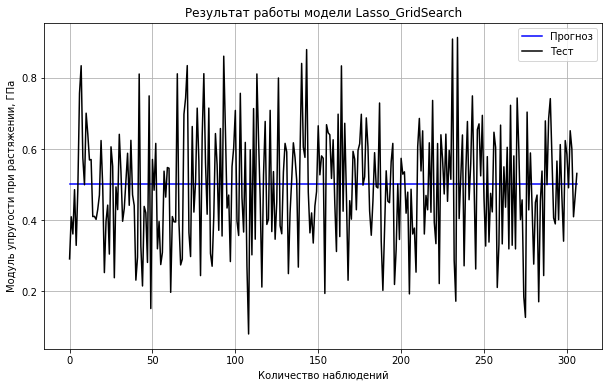

Lasso_GridSearch:
Время обучения:  0.0 с
Время предсказания:  0.0 с
MSE модели:  0.0291
r2 модели:  -0.0323
--------------------------------------------------------------------------------------------------------


In [107]:
for key, value in models_3.items():
    
    best_params_, models_3[key] = selection_hyperparameters(value, params[key], X_1_wo_train, y_1_wo_train, key)
    
    results_1 = model_analysis_df_1(models_3[key], results_1, key ,X_1_wo_train, y_1_wo_train, X_1_wo_test, 
                                                 y_1_wo_test, 'да', best_params_)

Выведем предварительную таблицу и посмотрим на результат работы моделей. Столбец с метрикой MSE отсортируем по возрастанию значения.

In [108]:
results_1.sort_values('MSE модели').style.apply(highlight_min, axis=None, subset=['MSE модели'])

Метрика модели совсем незначительно улучшилась. Улучшилась немного только метрика модели SGDRegressor, причём незначительно.

#### Деревья принятия решений

In [109]:
# Составим словарь и запишем в него модели для расчета

models_5 = {}
models_5['Tree'] = DecisionTreeRegressor(random_state=RANDOM_STATE)
models_5['Forest'] = RandomForestRegressor(random_state=RANDOM_STATE)

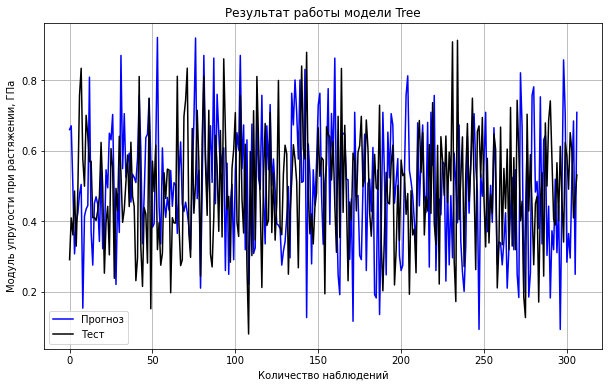

Tree:
Время обучения:  0.01 с
Время предсказания:  0.0 с
MSE модели:  0.0652
r2 модели:  -1.3994
--------------------------------------------------------------------------------------------------------


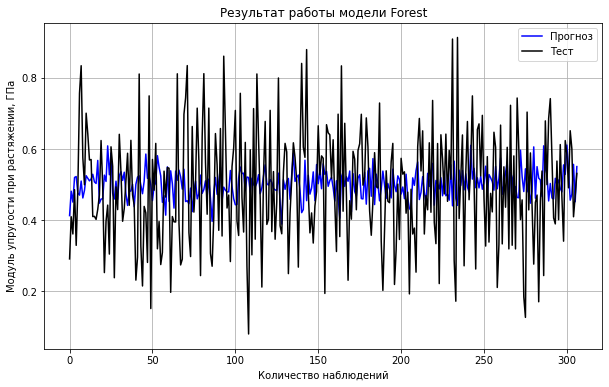

Forest:
Время обучения:  0.7 с
Время предсказания:  0.02 с
MSE модели:  0.0304
r2 модели:  -0.0813
--------------------------------------------------------------------------------------------------------


In [110]:
for key, value in models_5.items():
    
    results_1 = model_analysis_df_1(value, results_1, key ,X_1_wo_train, y_1_wo_train, X_1_wo_test, y_1_wo_test, 'нет', '-')   

Выведем предварительную таблицу и посмотрим на результат работы моделей. Столбец с метрикой MSE отсортируем по возрастанию значения.

In [111]:
results_1.sort_values('MSE модели').style.apply(highlight_min, axis=None, subset=['MSE модели'])

Модели решающее дерево и лес решений на стандартных параметрах оказались хуже линейных моделей, подберем гиперпараметры. Лучше же справилась с задачей модель RandomForestRegressor.

#### Деревья принятия решений, подбор гиперпараметров

Подберем гиперпараметры для моделей.

In [112]:
# Составим словарь и запишем в него модели для расчета и значения гиперпараметров для подбора

models_7 = {}
models_7['Tree_GridSearch'] = DecisionTreeRegressor(random_state=RANDOM_STATE)
models_7['Forest_GridSearch'] = RandomForestRegressor(random_state=RANDOM_STATE)

params = {}
params['Tree_GridSearch'] = {'max_depth':[ None, 1,2],
                            'max_leaf_nodes': [ None,1,2,3],
                            'min_samples_leaf':[1, 2,3]}

params['Forest_GridSearch'] =   {'max_depth':range(1, 5, 1),
                                 'max_leaf_nodes': [ None, 1,2],
                                 'n_estimators':range(1, 130, 5),
                                 'min_samples_leaf':range (7,10,1), 
                                'max_features': ['log2', 'sqrt']}

Гиперпараметры для модели  Tree_GridSearch {'max_depth': None, 'max_leaf_nodes': 2, 'min_samples_leaf': 1}
--------------------------------------------------------------------------------------------------------


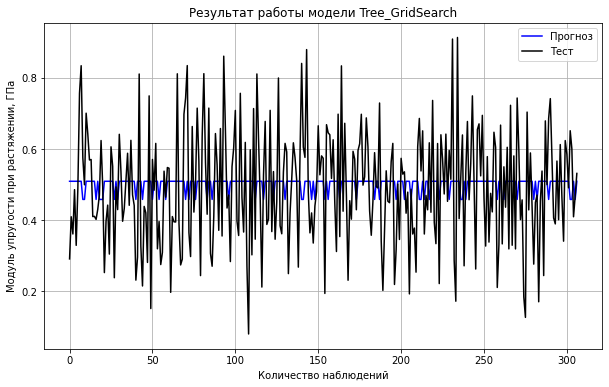

Tree_GridSearch:
Время обучения:  0.0 с
Время предсказания:  0.0 с
MSE модели:  0.0293
r2 модели:  -0.0403
--------------------------------------------------------------------------------------------------------
Гиперпараметры для модели  Forest_GridSearch {'max_depth': 1, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_samples_leaf': 9, 'n_estimators': 11}
--------------------------------------------------------------------------------------------------------


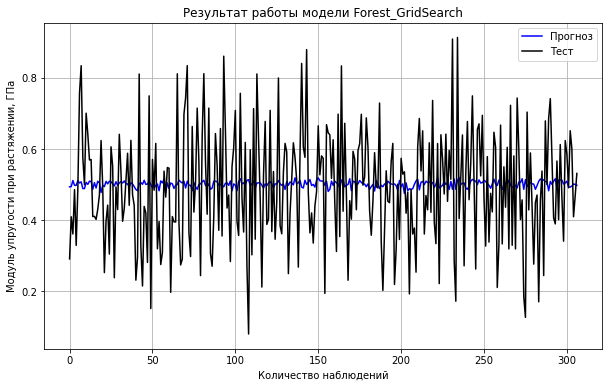

Forest_GridSearch:
Время обучения:  0.02 с
Время предсказания:  0.0 с
MSE модели:  0.029
r2 модели:  -0.0302
--------------------------------------------------------------------------------------------------------


In [113]:
for key, value in models_7.items():
    
    best_params_, models_7[key] = selection_hyperparameters(value, params[key], X_1_wo_train, y_1_wo_train, key)
    
    results_1 = model_analysis_df_1(models_7[key], results_1, key ,X_1_wo_train, y_1_wo_train, X_1_wo_test, y_1_wo_test, 'да', 
                                                                                                       best_params_)

Выведем предварительную таблицу и посмотрим на результат работы моделей. Столбец с метрикой MSE отсортируем по возрастанию значения.

In [114]:
results_1.sort_values('MSE модели').style.apply(highlight_min, axis=None, subset=['MSE модели'])

#### Метод опорных векторов

In [115]:
# Составим словарь и запишем в него модели для расчета

models_9 = {}
models_9['svr_rbf'] = SVR(kernel="rbf")
models_9['svr_lin'] = SVR(kernel="linear")

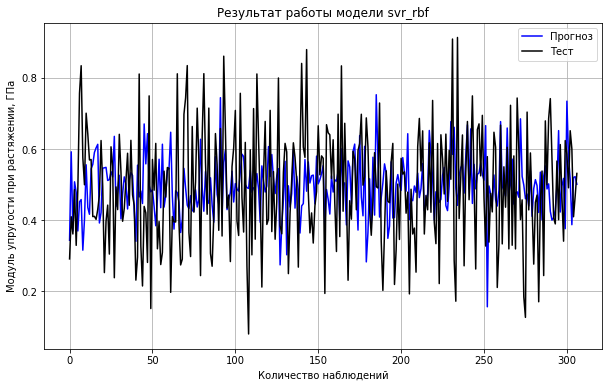

svr_rbf:
Время обучения:  0.04 с
Время предсказания:  0.02 с
MSE модели:  0.0339
r2 модели:  -0.2141
--------------------------------------------------------------------------------------------------------


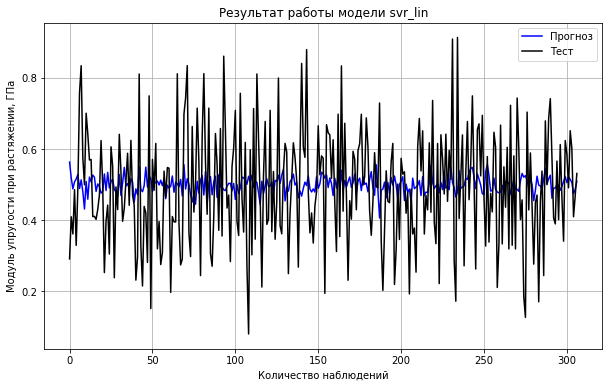

svr_lin:
Время обучения:  0.03 с
Время предсказания:  0.01 с
MSE модели:  0.0297
r2 модели:  -0.0519
--------------------------------------------------------------------------------------------------------


In [116]:
for key, value in models_9.items():
    
    results_1 = model_analysis_df_1(value, results_1, key ,X_1_wo_train, y_1_wo_train, X_1_wo_test, y_1_wo_test, 'нет', '-') 

Выведем предварительную таблицу и посмотрим на результат работы моделей. Столбец с метрикой MSE отсортируем по возрастанию значения.

In [117]:
results_1.sort_values('MSE модели').style.apply(highlight_min, axis=None, subset=['MSE модели'])

#### Метод опорных векторов, подбор гиперпараметров

Попробуем подобрать гиперпараметры к моделям опорных векторов.

In [118]:
 # Составим словарь и запишем в него модели для расчета

models_11 = {}
models_11['svr_rbf_GridSearch'] = SVR(kernel="rbf")
models_11['svr_lin_GridSearch'] = SVR(kernel="linear")

params = {}
params['svr_rbf_GridSearch'] = {'C':range (1,10,1),
                                  'degree':range (1,10,1),
                                  'epsilon': [1.1, 1.2, 1.0], 'cache_size':[200, 100, 300]}

params['svr_lin_GridSearch'] =  {'C':[11, 13,12],
                                  'degree':range (1,10,1),
                                  'epsilon': [0.8, 0.6, 1.7]} 


Гиперпараметры для модели  svr_rbf_GridSearch {'C': 1, 'cache_size': 200, 'degree': 1, 'epsilon': 1.1}
--------------------------------------------------------------------------------------------------------


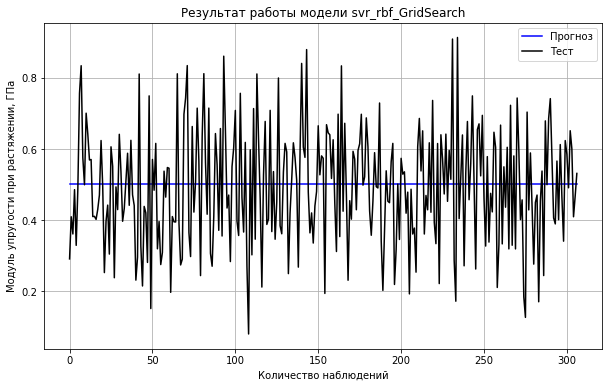

svr_rbf_GridSearch:
Время обучения:  0.0 с
Время предсказания:  0.0 с
MSE модели:  0.0291
r2 модели:  -0.032
--------------------------------------------------------------------------------------------------------
Гиперпараметры для модели  svr_lin_GridSearch {'C': 11, 'degree': 1, 'epsilon': 0.8}
--------------------------------------------------------------------------------------------------------


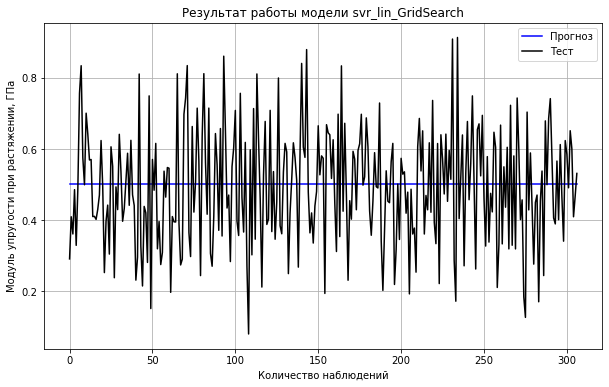

svr_lin_GridSearch:
Время обучения:  0.0 с
Время предсказания:  0.0 с
MSE модели:  0.0291
r2 модели:  -0.032
--------------------------------------------------------------------------------------------------------


In [119]:
for key, value in models_11.items():
    
    best_params_, models_11[key] = selection_hyperparameters(value, params[key], X_1_wo_train, y_1_wo_train, key)
    
    results_1 = model_analysis_df_1(models_11[key], results_1, key ,X_1_wo_train, y_1_wo_train, X_1_wo_test, y_1_wo_test, 'да', 
                                                                                                       best_params_)

Выведем предварительную таблицу и посмотрим на результат работы моделей. Столбец с метрикой MSE отсортируем по возрастанию значения.

In [120]:
results_1.sort_values('MSE модели').style.apply(highlight_min, axis=None, subset=['MSE модели'])

#### Алгоритмы бустинга

In [121]:
# Составим словарь и запишем в него модели для расчета

models_13 = {}
models_13['XGBoost'] = xgb.XGBRegressor(random_state=RANDOM_STATE,verbosity=0)
models_13['CatBoostRegressor'] = CatBoostRegressor(random_state=RANDOM_STATE,verbose=False)

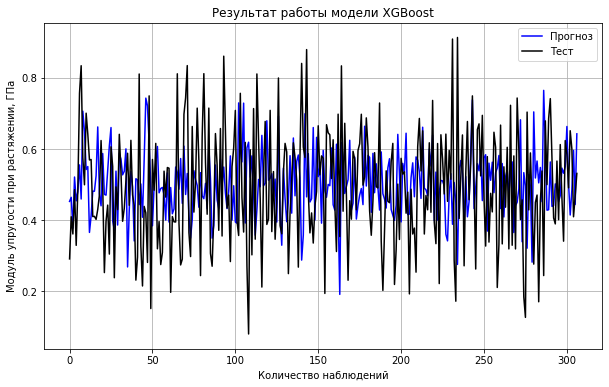

XGBoost:
Время обучения:  0.15 с
Время предсказания:  0.0 с
MSE модели:  0.0375
r2 модели:  -0.3461
--------------------------------------------------------------------------------------------------------


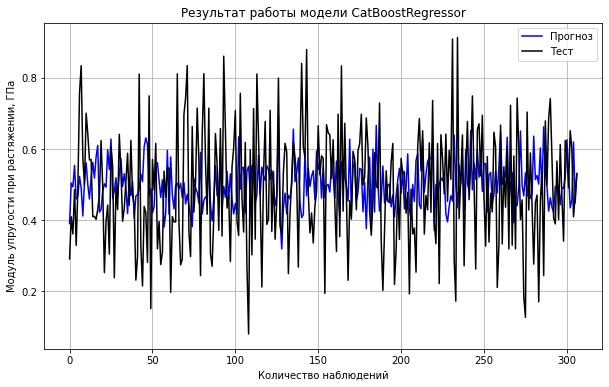

CatBoostRegressor:
Время обучения:  1.95 с
Время предсказания:  0.0 с
MSE модели:  0.0329
r2 модели:  -0.1719
--------------------------------------------------------------------------------------------------------


In [122]:
for key, value in models_13.items():
    
    results_1 = model_analysis_df_1(value, results_1, key ,X_1_wo_train, y_1_wo_train, X_1_wo_test, y_1_wo_test, 'нет', '-') 

Выведем предварительную таблицу и посмотрим на результат работы моделей. Столбец с метрикой MSE отсортируем по возрастанию значения.

In [123]:
results_1.sort_values('MSE модели').style.apply(highlight_min, axis=None, subset=['MSE модели'])

Модели показали практически одинаковый результат, подберем для них гиперпараметры.

#### Алгоритмы бустинга, подбор гиперпараметров

In [124]:
# Составим словарь и запишем в него модели для расчета

models_15 = {}
models_15['XGBoost_GridSearch'] = xgb.XGBRegressor(random_state=RANDOM_STATE,verbosity=0)
models_15['CatBoostRegressor_GridSearch'] = CatBoostRegressor(random_state=RANDOM_STATE,verbose=False)

params = {}
params['XGBoost_GridSearch'] = {'n_estimators': range (10, 100, 10),
                                'max_depth': range (1, 5, 1), 
                                'learning_rate': [0.3, 0.1,0.2]}

params['CatBoostRegressor_GridSearch'] =   {'n_estimators': range (10, 100, 10),
                                'max_depth': range (1, 5, 1), 
                                'learning_rate': [0.3, 0.1,0.2]}

Гиперпараметры для модели  XGBoost_GridSearch {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 10}
--------------------------------------------------------------------------------------------------------


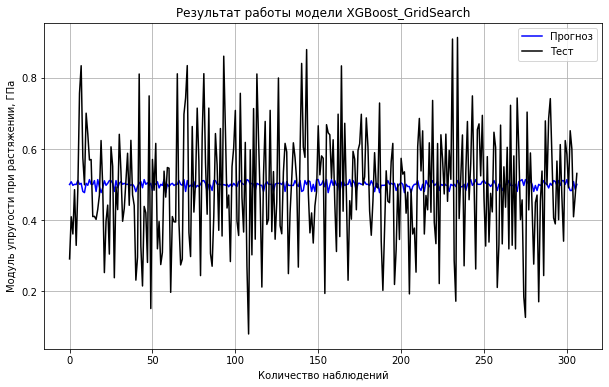

XGBoost_GridSearch:
Время обучения:  0.01 с
Время предсказания:  0.0 с
MSE модели:  0.0291
r2 модели:  -0.0312
--------------------------------------------------------------------------------------------------------
Гиперпараметры для модели  CatBoostRegressor_GridSearch {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 20}
--------------------------------------------------------------------------------------------------------


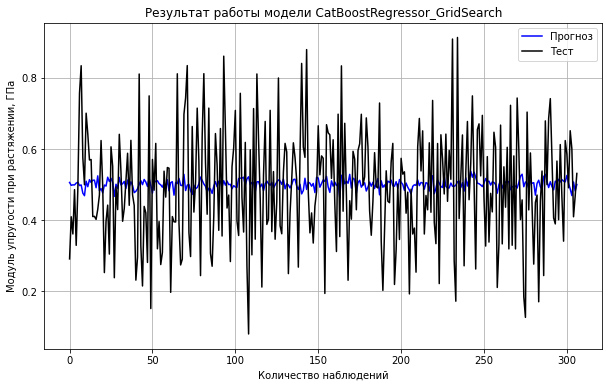

CatBoostRegressor_GridSearch:
Время обучения:  0.13 с
Время предсказания:  0.0 с
MSE модели:  0.029
r2 модели:  -0.0306
--------------------------------------------------------------------------------------------------------


In [125]:
for key, value in models_15.items():
    
    best_params_, models_15[key] = selection_hyperparameters(value, params[key], X_1_wo_train, y_1_wo_train, key)
    
    results_1 = model_analysis_df_1(models_15[key], results_1, key ,X_1_wo_train, y_1_wo_train, X_1_wo_test, y_1_wo_test, 'да', 
                                                                                                       best_params_)

In [126]:
results_1.sort_values('MSE модели').style.apply(highlight_min, axis=None, subset=['MSE модели', 'r2 модели'])

#### Нейронная сеть

Обучим нейронную сеть.

In [128]:
model_16 = Sequential()
model_16.add(Dense(units=28, input_dim=X_1_wo_train.shape[1], kernel_initializer='normal', activation='relu'))    
model_16.add(Dense(units=28, kernel_initializer='normal', activation='relu'))
model_16.add(Dense(1, kernel_initializer='normal'))
model_16.compile(loss='mean_squared_error', optimizer=adam_v2.Adam(learning_rate=1e-3), metrics=['mean_squared_error'])
model_16.fit(X_1_wo_train, y_1_wo_train ,batch_size = 20, epochs = 300, verbose=0)
    
MSE_16 = mean_squared_error(y_1_wo_test, model_16.predict(X_1_wo_test.values))
R2_16 = r2_score(y_1_wo_test, model_16.predict(X_1_wo_test.values))

print(color.BOLD + 'Neural network' +':'+ color.END)
print('MSE модели: ', round(MSE_16, 4))
print('r2 модели: ', round(R2_16, 4))
print('--------------------------------------------------------------------------------------------------------')  

10/10 [==============================] - 0s 1ms/step
Neural network:
MSE модели:  0.0261
r2 модели:  -0.0135
--------------------------------------------------------------------------------------------------------


In [144]:
model_16.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 28)                336       
                                                                 
 dense_59 (Dense)            (None, 28)                812       
                                                                 
 dense_60 (Dense)            (None, 1)                 29        
                                                                 
Total params: 1,177
Trainable params: 1,177
Non-trainable params: 0
_________________________________________________________________


In [129]:
results_1 = results_1.append({'Модель':'Neural network',
                              'MSE модели':'{:.4f}'.format(MSE_16),
                              'r2 модели':'{:.4f}'.format(R2_16),
                              'Время обучения, с':'-',
                              'Время предсказания, с':'-',
                              'Общее время, с':'-',
                              'Подбор гиперпараметров':'-',                        
                              'Значения гиперпараметров':'-', 
                              'Данные': 'df_s'}, ignore_index=True)

### Вывод по первой части:

Выведем итоговую таблицу с прогнозми "Модуль упругости при растяжении, ГПа" для всех моделей.

In [130]:
results_1.sort_values('MSE модели').style.apply(highlight_min, axis=None, subset=['MSE модели', 'r2 модели'])

В процессе работы были выполнены:

- Объединение данных из двух таблиц;
- Анализ данных;
- Предобработка данных;
- Разбивка данных на обучающую и тестовую выборки в соотношении 70:30;
- Обучение моделей и поиск оптимальных гиперпараметров;
- Построены графики значения целевого признака и предсказания.

Качество предсказаний всех моделей получилось низкое. Не удалоссь найти модель которая хорошо предсказывает целевой признак "Модуль упругости при растяжении, ГПа".

Для обучения мы использовали несколько моделей: 
- линейные модели;
- деревья принятия решений;
- алгоритмы бустинга;
- метод опорных векторов;
- нейронная сеть. 

Модели сначала обучали без гиперпараметров, затем с подбором гиперпараметров. для каждой модели были рассчитаны значения метрики MSE и R2, построены графики значений целевого признака и предсказания модели. Обучение моделей проходило на выборке с наличием выбросов, так как их удаление ухудшало работу моделей. Гиперпараметры определялись при помощи метода «GridSearch». Была составлена итоговая тоблица со значениями метрик всех моделей.

Лучше всех справилась нейронная сеть, алгоритмы бустинга, SVR и Lasso, причем их результат нельзя назвать хорошим. Метрика получилось не на много лучше, чем у модели предсказывающей только среднее. Возможно можно получить лучшее значение метрик, если изменить архитектуру нейронной сети и подобрать другие более оптимальные гиперпараметры для моделей.

Худшими моделями для прогноза этого признака оказались решающее дерево и линейная регрессия.

Большинство моделей показали метрики близкие или такие же как у модели предсказывающей среднее.
Возможно, это связано с тем что, если посмотреть на графики рассеяния, они все имеют вид облака точек примерно одинаковый, близкий к окружности. И плоскость со значениями модели предсказывающая среднее пройдет примерно по серидине облака точек в n-мерном пространстве. При этом она как раз пройдет через максимальное количество точек. Поэтому, вероятно, все линейные модели также стремяться к средней плоскости. Для этих данных лучше выбирать более сложные модели такие как нейронные сети.

При этом для успешного прогнозирования данных недостаточно, около 1000 строк это слишком мало, так как даже удаление выбросов повлияло на метрику в худшую сторону, возможно также, недостаточно признаков.

Необходимо уточнить у специалиста, который занимался сбором данных:
- корректны ли значения признаков;
- можно ли увеличить количество экспериментов;

Также возможным решением будет добавление признаков, при этом надо хорошо разбираться в сфере самих композитных материалов. Необходимо знать на какие признаки стоит обратить внимание, в каких величинах они должны измеряться и нет ли ошибок при съеме параметров в ходе экспериментов.